# Table of Contents

IMPORTANT NOTE: For most optimal experience, please open in VSCode or JupyterLab. In classic Jupyter Notebook, internal links may not behave consistently due to interface limitations.

1. [Preamble](#Preamble)
2. [Importing Libraries](#Importing-Libraries)
3. [Cleaning Datasets](#cleaning-datasets)
>3.1 [Dealing with Missing Values](#missing-values)  
4. [Task 1: Strategic Insight - Cumulative Academic Achievement](#Task-1)<br>
>4.1 [Splitting Dataset](#splitting-dataset)<br>
>4.2 [Finding Cumulative Grades](#finding-CGs)<br>
>4.3 [Plotting Histograms](#Histograms)<br>
>4.4 [Analysing Trends & Patterns](#trends-analysis)<br>
>>4.4.1 [Campus Level Analysis](#campuslevel-analysis)<br>
>>4.4.2 [Year Level Analysis](#yearlevel-analysis)<br>
>>4.4.3 [KLA Analysis](#kla-analysis)
>>
>4.5 [Key Takeaways](#task1takeaaways) 
5. [Task 2: Predictive Modelling - Mathematics 1 Performance (Year 7 Only)](#Task-2)<br>
>5.1 [Preparing Datasets](#preparing-datasets)  
>5.2 [Identifying Contributing Features](#identifying-contributing-features)  
>5.3 [Benchmarking](#Benchmarking)  
>5.4 [Identifying Overperformers & Underperformers](#identifying-classes)  
>5.5 [Key Takeaways](#task2takeaaways)

<a id="Preamble"></a>
## 1. Preamble 

This notebook contains the data analysis results of the data analysis tasks as requested.

Task 1 involved the exploration of the dataset and the identification and visualisation of the cumulative grades (CGs) for primary and secondary school students. In this task, the CGs for the subset of primary and secondary school students were calculated as described in the Academic Reporting Policy. Histograms of the letter grades were then plotted to better understand the distribution of students within the subgroups. Finally, further analysis and exploration of the data was performed (specific details discussed in Section 4.4).


Task 2 required the development of a model to predict Mathematics 1 grade of Year 7 students. In this task, all available data with the exception of the already available Mathematics 1 score was used to build the model. Linear Regression and Random Forest Classification was used for prediction.

<a id="Importing-Libraries"></a>
## 2. Importing Libraries 

Before beginning, we import the libraries we will be using.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seaborn
import openpyxl as openpyxl
from scipy import stats
import re

# Scikit libraries
import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression

# Silencing warning
pd.set_option('future.no_silent_downcasting', True)

<a id="cleaning-datasets"></a>
## 3. Cleaning Datasets

Once we have loaded the relevant libraries, we need to import the datasets required. For this task, we have two datasets:
1. results.xlsx : containing information on each student's year level, campus, subject, score and grade. The respective effort, behaviour, and attendance scores are also included for each subject.
2. subjects.xlsx : containing information on each subject's credit, key learning area group, and cutoff group as defined in the Academic Reporting Policy.

In [2]:
# Importing Datasets
stud_res = pd.read_excel("C:/Users/barca/Desktop/Data_Analysis_Task/results.xlsx")
subj_info = pd.read_excel("C:/Users/barca/Desktop/Data_Analysis_Task/subjects.xlsx")

Before performing any statistical analysis, we first need to clean the dataset by removing unnecessary information (such as missing values). These data points can increase the amount of noise in the dataset, leading to biased results. As such, further inspection is required. Notably, we will not be removing outliers in this task as this is a simple exploration and not a model building exercise. Outliers will only be removed if they lead to aberrant visual representations and trends, affecting result interpretation.

Then, we add on columns that we require to calculate the CG and for further inspection in Task 1.3. This includes credit, the key learning area, and cutoff group. 

<a id="missing-values"></a>
### 3.1 Dealing with Missing Values 

To identify if the dataset has any missing values, we can first view the underlying data structure.

In [3]:
stud_res.info() # Checking for null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25407 entries, 0 to 25406
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Student Code  25407 non-null  int64  
 1   Gender        25407 non-null  object 
 2   Year          25407 non-null  object 
 3   Class Code    25407 non-null  object 
 4   Subject       25407 non-null  object 
 5   Score         25229 non-null  float64
 6   Grade         25381 non-null  object 
 7   Behaviour     25400 non-null  object 
 8   Effort        25399 non-null  object 
 9   Attendance    25404 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 1.9+ MB


It would appear that some columns contain null values. To get a better idea of how significant the percentage of null values are, we can inspect this further before deciding our next course of action. We will aim to look at the percentage and total of missing values per column. This can help us decide how to handle the missing values.

There are several different categories of missing data. Broadly speaking, these can be grouped into three:
1. Missing Completely at Random (MCAR)
2. Missing At Random (MAR)
3. Missing Not At Random (MNAR)

MCAR occurs when data is missing independent of any observed or unobserved variables. In other words, the missing data does not follow a discernable pattern and its presence in a dataset is a random occurance. For example, some participants in a survey may unintentionally skip survey questions. When data is MCAR, the size of the data available for analysis decreased thus decreasing the statistical power of the analysis. However, this type of missingess does not introduce any bias.

In MAR, the missingness is related to observed features in the dataset and is also not related to unobserved variables in the study. A classical example of is a tobacco survey. In this survey, younger participants may be less willing to report how much they smoke compared to older participants. This would lead to a systematic missingness in the data related to the age of the participants. In these cases, proper imputation methods should be conducted to avoid bias in the analysis, affecting the validity of results.

Finally, MNAR occurs when the missing data is systematically related to unobserved variables. Here, the missingness is not random and is associated with the occurance of external factors. In the tobacco example, missing data may be considered MNAR if participants who smoke more intentionally do not report their smoking habits. This type of missingness is the hardest to handle as it cannot be properly addressed in the analysis. As such, any likely estimate of the final hypothesis may be biased.

To identify the type of missingness in this dataset, further investigation in the patterns of missing data is required. We will handle the data according to the type of missingness present. 

In [3]:
# Finding percentage and total of missing values per column
total_val = stud_res.isnull().sum().sort_values(ascending=False)
perct_val = ((stud_res.isnull().sum()/stud_res.isnull().count())*100).sort_values(ascending=False)
missing_dt = pd.concat([total_val,perct_val], axis=1,keys=['Total','Percent'])
print(missing_dt)

              Total   Percent
Score           178  0.700594
Grade            26  0.102334
Effort            8  0.031487
Behaviour         7  0.027551
Attendance        3  0.011808
Student Code      0  0.000000
Gender            0  0.000000
Subject           0  0.000000
Year              0  0.000000
Class Code        0  0.000000


As demonstrated, while the percentage of missing values were not significant (and thus, not a cause for alarm), there is a substantial number of mising values present in the 'Score' and 'Grade' columns. As such, we will continue to inspect this further. The lack of data may be due to several factors including:
1. Students undertaking a VET subject or modified assessments
2. Accidental blanks left in by teachers when filling in respective scores and grades

Thus, we will pull out a subset of data with missing values in either column to determine if the data is missing due to random chance or not. More specifically, we are looking for any potential associations between modified assessments or VET subjects and missing scores.

In [4]:
# Subsetting the larger dataset to only include the rows with null values reported 
missval_dt = stud_res['Score'].isnull() | stud_res['Grade'].isnull()
# Turn this into a data frame to print it as an actual table
df_missval = pd.DataFrame(stud_res[missval_dt])
df_missval.style # Printing a basic table

,Student Code,Gender,Year,Class Code,Subject,Score,Grade,Behaviour,Effort,Attendance
170,77287,f,Year 6 EPC,D06-MAT-D,Mathematics (Year 6),nan,M,GO,GO,85.900000
864,4420,f,Year 11 EGC,E11-VBUSU12-2,VCE VET Business U12,nan,CO,A,A,78.700000
1641,89896,f,Year 11 EGC,E11-VBUSU12-2,VCE VET Business U12,nan,CO,A,A,86.400000
1970,69370,f,Year 11 EGC,E11-VBUSU12-2,VCE VET Business U12,nan,CO,A,A,97.300000
2283,92416,f,Year 10 EGC,E10-CERT2WS-4,Certificate II in Workplace Skills,nan,NC,C,C,82.700000
2893,88048,m,Year 4 KBC,K04-ENG-B,English (Year 4),nan,M,GO,GO,83.100000
2911,94564,m,Year 3 KBC,K03-ENG-A,English (Year 3),nan,M,AC,GO,85.300000
2976,63475,m,Year 9 MFC,M09-HIS1-2,History 1,nan,M,B,D,89.700000
2978,63475,m,Year 9 MFC,M09S1-TUR3-6,Turkish 3,nan,M,B,B,88.100000
2979,63475,m,Year 9 MFC,M0910S1-WDCS-5,Web Design and Cyber Security,nan,M,C+,C+,81.100000


From the above, we can see that a vast majority of the non-null values are indeed a result of modified assessments or VET subjects. As these subject scores are intentionally left blank (i.e. missing not at random), we can disregard them as aberrant data entries. Given that these results are reported for their respective students, we will be analysing this smaller subset of data separately below. For the larger dataset, subjects marked as modified assessment or VET will be dealt with below. 

For the data points where:
* The student's score in a subject is missing AND
* The subject itself is neither a VET subject not was any modified assessments given
We will include them as we assume they are missing completely at random.

Of particular interest here was the presence of missing values for both the 'Score' and 'Grade' columns in some rows. Most concerningly was Student #108817 and Student #4606. Both these students had missing scores and grades for all their subject. Student #108817 was especially interesting as depite the lack of scores and grades, their behaviour, effort, and attendance was almost perfect. This student's inclusion in the dataset may have been an accident as they may have been used as a placeholder example for how data should be sturcured. Regardless, due to the lack of data available for both columns of interest here, both students will be removed. 

Additionally, we will merge the information available from the 'subjects.xlsx' file to the available 'stud_res' dataframe for downstream calculations. We can work from this newly merged dataframe moving forward. We will also replace of a couple of campus codes to match valid campus codes. Specifically, we will replace 'EPC' with 'DLC' and 'EGC' with 'EMC'.

In [3]:
# Dropping the columns and merging dataframes
df_task = pd.merge(stud_res,subj_info,how='left',left_on='Subject',right_on='Subject') # Add columns from 'subjects.xlsx' to help calculate the CGs
df_task.head() # Checking that the code has worked

,Student Code,Gender,Year,Class Code,Subject,Score,Grade,Behaviour,Effort,Attendance,Credit,KLA,Cutoff Group
0,105844,m,Year 7 KBC,K07S1-DIG-3,Digital Technologies,60.0,D+,A,C+,88.9,2,TEC,G3
1,105844,m,Year 7 KBC,K07-ENG1-6,English 1,77.0,C+,A,B,90.7,4,ENG,G3
2,105844,m,Year 7 KBC,K07-HPE1-15,Health and Physical Education 1,65.0,C,A+,B,89.2,2,HPE,G3
3,105844,m,Year 7 KBC,K07-HUM1-1,Humanities 1,59.0,D+,A,A+,88.0,3,HUM,G3
4,105844,m,Year 7 KBC,K07-MAT1-4,Mathematics 1,79.0,B+,A,A,88.0,4,MAT,G2


In [5]:
# Replacing campus codes
# Making a dictionary
campus_replace = {"EPC":"DLC", "EGC":"EMC"}
# Making a pattern
    # re.escape(key) escapes special characters in the substring that may be treated as proper characters in the regex pattern (e.g. * or ?)
    # '|'.join(...) joins the escaped characters with 'OR' to create a regex patern matching the substrings of interest
pattern = '|'.join(re.escape(key) for key in campus_replace.keys()) 
# Applying pattern to the 'Year' column
df_task['Year'] = df_task['Year'].str.replace(pattern, lambda match: campus_replace[match.group(0)], regex=True)
# Checking
df_task['Year'].unique()

array(['Year 7 KBC', 'Year 9 MFC', 'Year 7 EMC', 'Year 10 EMC',
       'Foundation DLC', 'Year 8 KBC', 'Year 4 DLC', 'Year 1 DLC',
       'Year 10 IDC', 'Year 3 DLC', 'Year 10 KBC', 'Year 5 KBC',
       'Year 6 DLC', 'Year 3 KBC', 'Year 4 IDC', 'Year 8 IDC',
       'Year 3 SPC', 'Year 8 MFC', 'Year 12 KBC', 'Year 1 IDC',
       'Foundation KBC', 'Year 1 KBC', 'Year 10 MFC', 'Year 5 DLC',
       'Year 12 MFC', 'Year 9 IDC', 'Year 12 IDC', 'Year 12 EMC',
       'Year 11 EMC', 'Year 7 IDC', 'Year 1 SPC', 'Year 11 IDC',
       'Year 8 EMC', 'Year 6 IDC', 'Year 11 MFC', 'Foundation IDC',
       'Year 3 IDC', 'Year 2 IDC', 'Foundation SPC', 'Year 9 EMC',
       'Year 7 MFC', 'Year 9 KBC', 'Year 5 SPC', 'Year 6 KBC',
       'Year 4 KBC', 'Year 2 DLC', 'Year 2 KBC', 'Year 5 IDC',
       'Year 4 SPC', 'Year 2 SPC', 'Year 11 KBC', 'Year 6 SPC'],
      dtype=object)

In [6]:
# Removing the two previous identified students from the dataframe
to_remove = [108817, 4606] # Making a list with the student IDs
df_task = df_task[~df_task['Student Code'].isin(to_remove)] # '~' is to keep everything in in the list 'to_remove'

Several other data points should be removed. This include subject rows where:
* Both the 'Score' and 'Grade' contain null values.
* 'Grade' contains either 'M', 'CO', or 'NC' as modified assessments and VET subjects are not included in the Grade Point Average (GPA), Weighted Average Marks (WAM), and CGs

We remove these points to avoid artificially inflating or deflating a student's scores as the calculations for GPA, WAM, and CGs call for the summation of a subject's credit point regardless of the student's score or grade. This will affect the final CG calculated. Thus, we can ensure accuracy and avoid any potential biases being introduced in the analysis.

In [7]:
# Remove only the rows where both Score and Grade are missing
df_task = df_task[~(df_task['Score'].isna() & df_task['Grade'].isna())] 

In [8]:
# Removing subjects where scores were missing due to modified assessments or VET subjects
mod_assess = ['M', 'CO','NC'] # Making a list of the grades we want to filter out
df_CGcalc = df_task[~df_task['Grade'].isin(mod_assess)] # We will make a new dataframe as we don't want to remove them from the analysis entirely

One last item to deal with is the issue of subjects where learning support is required. For these, the Academic Reporting Policy states that "these codes are not used in WAM or GPA calculations but appear in reports where relevant". As they are not included in final grade calculations, we should remove them to avoid overinflating a student's final cumulative grade.

In [9]:
# Removing Subjects that required learning support subjects
# Making a list of the strings we want to remove
    #['f'Y{i}' for ...] creates a f-string that inserts the value of i into the string, dynamically searching for the different support levels
learn_supp = ['YF', 'YF.5'] + [f'Y{i}' for i in range(1, 11)] + [f'Y{i}.5' for i in range(1, 10)] 
# Further filtering the above dataframe
df_CGcalc = df_CGcalc[~df_CGcalc['Grade'].isin(learn_supp)]
# Checking that the subjects with the learning support grades have been removed
df_CGcalc['Grade'].unique()

array(['D+', 'C+', 'C', 'B+', 'A', 'B', 'D', 'C3', 'C1', 'C4', 'C2', 'B2',
       'E', 'E+', 'C5', 'B1', 'A+'], dtype=object)

<a id="Task-1"></a>
## 4. Task 1: Strategic Insight - Cumulative Academic Achievement 

This section will follow the requested analysis tasks in the Data Analysis Task handout provided. As the initial dataset has been filtered and cleaned appropriately for this exploratory exercise, we can begin the task.

<a id="splitting-dataset"></a>
### 4.1 Splitting Dataset 

As the task calls for the calculation of the CGs and histogram visualisation for both the primary and secondary student cohorts, we first split the larger dataframe into two smaller dataframes.

We begin with the primary cohort:

In [12]:
# Primary cohort dataframe formation
# Setting regex pattern to search for matches.
pat_pri = r'Year\s[1-6]\s[A-Z]' # The pattern will search for a single digit number between 1 and 6 after 'Year' followed by any alphabet.
# Forming the dataframe
df_primary = df_CGcalc[ 
    df_CGcalc['Year'].str.contains('Foundation') | # using 'OR' statement to include both foundation and Year 1 - 6 in primary set
    df_CGcalc['Year'].str.contains(pat_pri)
].reset_index(drop=True) # Resetting index to maintain consistency in the new dataframe while dropping the old index
# Rearranging based on year level and student code (in ascending order)
df_primary = df_primary.sort_values( 
    by=["Year","Student Code"])
print(df_primary) # Quick print to have a quick look at the data structure.
# Checking that only Foundation and Year 1 - 6 levels were included.
check_pri = df_primary['Year'].unique() 
print(check_pri)

       Student Code Gender            Year  Class Code  \
10686        101110      f  Foundation DLC   D00-ENG-C   
10687        101110      f  Foundation DLC   D00-MAT-C   
10688        101110      f  Foundation DLC  D00-STEM-C   
10689        101110      f  Foundation DLC   D00-HPE-C   
10690        101110      f  Foundation DLC  D00-PART-C   
...             ...    ...             ...         ...   
9491         108715      f      Year 6 SPC  S06-CART-A   
9492         108715      f      Year 6 SPC  S06-PART-A   
9493         108715      f      Year 6 SPC    S06-RV-A   
9494         108715      f      Year 6 SPC     S06-ARA   
9495         108715      f      Year 6 SPC   S06-HPE-A   

                                          Subject  Score Grade Behaviour  \
10686                        English (Foundation)   66.0    C4        EX   
10687                    Mathematics (Foundation)   98.0     A        EX   
10688                           STEM (Foundation)   84.0    C1        EX   

Then, we form the secondary cohort:

In [13]:
# Secondary cohort dataframe formation
# Regex pattern for searching
pat_sec1 = r'Year\s[7-9]\s[A-Z]' # This searchers for single digit between 7 and 9 (to find Year 7 - Year 9 students)
pat_sec2 = r'Year\s[1][0-2]\s[A-Z]' # This searchers for Year 10 - 12 students. '[1]' is to specify that the first number must be one.
# Making data frame. The process is the same as above
df_secondary = df_CGcalc[
    df_CGcalc['Year'].str.contains(pat_sec1) |
    df_CGcalc['Year'].str.contains(pat_sec2)
].reset_index(drop=True)

In [14]:
# Rearranging according to year level and sorting by student code
# We have to make an explict list for this as they do not follow the order we want
sec_year = ['Year 7 EMC','Year 7 MFC','Year 7 KBC','Year 7 IDC','Year 8 EMC','Year 8 MFC',
 'Year 8 KBC','Year 8 IDC','Year 9 EMC','Year 9 MFC','Year 9 KBC', 'Year 9 IDC',
 'Year 10 EMC','Year 10 MFC', 'Year 10 KBC', 'Year 10 IDC', 'Year 11 EMC',
 'Year 11 MFC', 'Year 11 KBC', 'Year 11 IDC', 'Year 12 EMC', 'Year 12 MFC',
 'Year 12 KBC', 'Year 12 IDC'] # List
df_secondary['Year'] = pd.Categorical(df_secondary['Year'], categories=sec_year, ordered=True)
# Sort
df_secondary = df_secondary.sort_values(by=['Year', 'Student Code'])
print(df_secondary) # Quick check of structure
# Checking that only Year 7 - 12 students were included.
check_sec = df_secondary['Year'].unique()
print(check_sec)

['Year 7 EMC', 'Year 7 MFC', 'Year 7 KBC', 'Year 7 IDC', 'Year 8 EMC', ..., 'Year 11 IDC', 'Year 12 EMC', 'Year 12 MFC', 'Year 12 KBC', 'Year 12 IDC']
Length: 24
Categories (24, object): ['Year 7 EMC' < 'Year 7 MFC' < 'Year 7 KBC' < 'Year 7 IDC' ... 'Year 12 EMC' < 'Year 12 MFC' < 'Year 12 KBC' < 'Year 12 IDC']


<a id="finding-CGs"></a>
### 4.2 Finding Cumulative Grades 

Now that we have subsetted the main dataframe, we can begin to calculate the CGs for the primary and secondary cohorts separately. We perform the operation this way as the methodology to calculate the final CG differs between the two. This section only deals with the calculation of the cumulative grades. Visualisation of these distributions across a range of levels can be found below.

Again, we will begin with the primary cohort. As stated in the Academic Reporting Policy, we need to calculate the WAM first before conversion to the corresponding CG letter.

In [15]:
# Primary Cohort CGs
#First make a function to find the WAM
def cg_primary(dataset_name):
    return (sum(dataset_name['Score']*dataset_name['Credit']) / sum(dataset_name['Credit'])) # This follow the steps outlined in the Academic Reporting Policy Handout
#Apply to each student and include it as a separate dataframe
primary_result = df_primary.groupby('Student Code').apply(cg_primary, include_groups=False).reset_index() # Calling function using '.apply' and performing on individual students using 'groupby'
primary_result = primary_result.set_axis(['Student Code','WAM'],axis=1) # Setting the column names of the new dataframe. 'axis=1' refers to the column (i.e. we are applying the code to the columns)
primary_result.head() # Quick peek to ensure that the code is working

# Now we convert the WAM to the CGs. This follows the table provided in the policy.
def pri_CG_convert(dataset_name):
    """
    This functions iterates down the 'WAM' column and checks it against the rules laid out.
    If the number matches, it returns the corresponding letter grade.
    If the number does not match, it moves down a letter grade until "E".
    """
    if dataset_name['WAM'] >= 92:
        return "A+"
    elif dataset_name['WAM'] >= 89:
        return "A"
    elif dataset_name['WAM'] >= 86:
        return "B+"
    elif dataset_name['WAM'] >= 82:
        return "B"
    elif dataset_name['WAM'] >= 77:
        return "C+"
    elif dataset_name['WAM'] >= 72:
        return "C"
    elif dataset_name['WAM'] >= 66:
        return "D+"
    elif dataset_name['WAM'] >= 61:
        return "D"
    elif dataset_name['WAM'] >= 55:
        return "E+"
    else:
        return "E"
# Finding the CGs of the students
primary_result['Cumulative Grade']=primary_result.apply(pri_CG_convert, axis=1) # Applying the above function to a new column for CGs
# Plotting the resulting tables
pri_res_tab = pd.DataFrame(primary_result)
pri_res_tab.style

,Student Code,WAM,Cumulative Grade
0,74260,61.095238,D
1,76024,64.181818,D
2,76249,84.047619,B
3,76750,66.666667,D+
4,76819,60.625000,E+
5,77287,65.294118,D
6,78043,81.181818,C+
7,78694,84.500000,B
8,79360,87.454545,B+
9,79384,91.590909,A


Then, we find the CGs for the secondary cohort. Here, the following steps will be performed:
1. Convert the subject grades to their respective grade values
2. Use the grade value to calculate the GPA
3. Convert the GPA to the cumulative grade

In [16]:
# Secondary Cohort CGs
# Converting the subject grades into respective grade values 
# First, we make a dictionary for referencing during the conversion
gradeval_dict = {'A+':100,'A':90,'B+':80,'B':70,'C+':60,'C':50,'D+':40,'D':30,'E+':20,'E':10} # Making dictionary
# Converting and adding a new column 'Grade Value'
df_secondary['Grade Value']= df_secondary['Grade'].map(gradeval_dict).fillna(0) # Converting using '.map'. We add 'fillna' for learning support subjects entries
df_secondary.head()

# Defining and applying function for GPA calculation
def GPA_calc(dataset_name): # This is based on the reporting policy handout provided
    return (sum(dataset_name['Grade Value']*dataset_name['Credit']) / sum(dataset_name['Credit']))
secondary_result = df_secondary.groupby('Student Code').apply(GPA_calc, include_groups=False).reset_index() # As above, applying the function to individual students to find their GPA
secondary_result = secondary_result.set_axis(['Student Code','GPA'],axis=1) # Setting column names of the new dataframe
secondary_result.head()

# Converting GPA to Cumulative Grade
def sec_CG_convert(dataset_name): # Cut-offs and respective letter grades follow the Academic Reporting Policy booklet
    """
    Same as the above WAM to Cumulative Grade Process.
    We use a different function as the cut-offs differ between the primary and secondary schools.
    """
    if dataset_name['GPA'] >= 91:
        return "A+"
    elif dataset_name['GPA'] >= 84:
        return "A"
    elif dataset_name['GPA'] >= 76:
        return "B+"
    elif dataset_name['GPA'] >= 67:
        return "B"
    elif dataset_name['GPA'] >= 58:
        return "C+"
    elif dataset_name['GPA'] >= 50:
        return "C"
    elif dataset_name['GPA'] >= 42:
        return "D+"
    elif dataset_name['GPA'] >= 35:
        return "D"
    elif dataset_name['GPA'] >= 28:
        return "E+"
    else:
        return "E"
# Finding the cumulative grade of the students
secondary_result['Cumulative Grade']=secondary_result.apply(sec_CG_convert, axis=1) # Applying the function to a new column called 'Cumulative Grade'
# Plotting the resulting tables
sec_res_tab = pd.DataFrame(secondary_result)
sec_res_tab.style

,Student Code,GPA,Cumulative Grade
0,3004,42.000000,D+
1,3022,66.666667,C+
2,3079,100.000000,A+
3,3100,60.000000,C+
4,3112,67.500000,B
5,3127,52.500000,C
6,3130,36.666667,D
7,3133,20.000000,E
8,3172,73.333333,B
9,3181,33.333333,E+


<a id="Histograms"></a>
### 4.3 Plotting Histograms 

Now that we have calculated the cumulative grades for both the primary and secondary school cohort, we can plot their respective histograms. As both groups require the use of similar lines of code, we can simply define a function and pass the 'primary_result' and 'secondary_result' dataframes through this function to return the histogram plots.

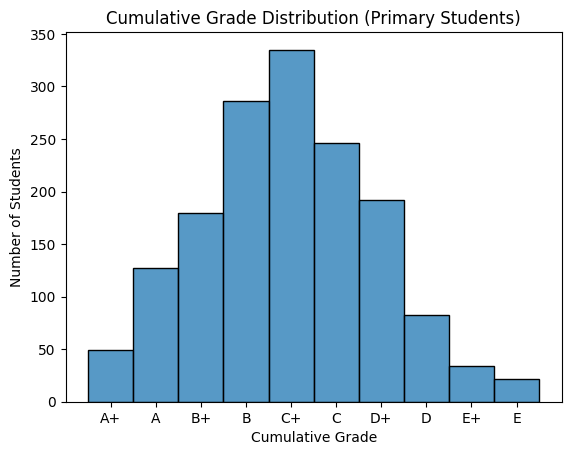

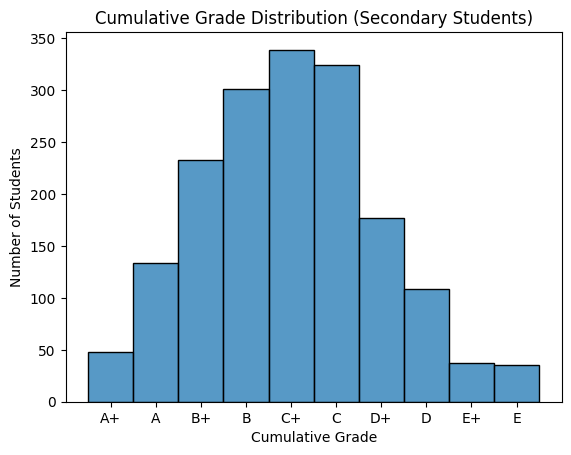

In [17]:
# Defining function
def hist_plot(dataset_name, grade_col='Cumulative Grade', title='Cumulative Grade Distribution'): 
    """
    This function works to plot the distribution of cumulative grades.
    The grade column is turned to categorical to use it as individual groups when plotting.

    Important Notes:
    - grade_col: the column with the cumulative grade
    - title: plot title (optional)
    """
    # Specifying the order we want the grades to be in
    grade_lst = ["A+","A","B+","B","C+","C","D+","D","E+","E"]

    # Setting CG column as categorical with pre-defined order
    dataset_name[grade_col]=pd.Categorical(dataset_name[grade_col], categories=grade_lst, ordered=True) 

    # Start a new figure - to plot them separately 
    plt.figure()

    # Sort the dataframe by the grade column
    dataset_name = dataset_name.sort_values(grade_col)
        
    # Plot the histogram
    plot = seaborn.histplot(data=dataset_name, x=grade_col, discrete=True)
    # Add labels and title
    plt.title(title)
    plt.xlabel("Cumulative Grade") # Labelling the x-axis
    plt.ylabel("Number of Students") # Labelling the y-axis
    return plot # This plots the histogram below

# Plotting Distributions - we specify the title for both plots
pri_plt = hist_plot(primary_result, title="Cumulative Grade Distribution (Primary Students)") 
sec_plt = hist_plot(secondary_result, title="Cumulative Grade Distribution (Secondary Students)")

As shown in the histograms above, both the primary and secondary cohort of students have highly similar cumulative grade distributions. Both are normally distributed, with a majority of students having grades between B to C. There was noticably less primary students that achieved a cumulative grade of B+ and D+ compared to the secondary student cohort. 

This difference may be due to several factors including:
1. A greater number of students in the secondary cohort
2. The secondary students are better overall academic performers
3. Prior filtering of learning support subjects and modified assessments/VET subjects removed more primary students than secondary from the cumulative grade calculations.

Further investigations into this discrepancy would be interesting. However, due to the time constraints of this task, we will not be doing so.

<a id="trends-analysis"></a>
### 4.4 Analysing Trends & Patterns  

Finally, we can perform further analysis on any trends, patterns, or anomalies in the dataset provided. As specified in the brief, we will focus on:
1. Campus level
2. Year level
3. Key Learning Area (KLA) level

As this task has heavily focussed on the analysis and visualisation of CGs for students, we will be looking at grade distributions across all three levels. Additionally, it will be interesting to identify any trends in the number of modified assessments or VET subjects undertaken at the campus, year, and KLA level. Due to the time constraints of this task, we will only restrict this analysis to three to four points of interest (specific details below).

We begin by preparing the datasets required. For this sub-task, we need to:
* Match the year level to individual students from the 'primary_result' and 'secondary_result' dataframes
* Split the 'Year' column in the 'primary_result', 'secondary_result', 'df_primary', and 'df_secondary' dataframes to obtain both the student's year level and campus individually

As both these steps involve the repetition of code, we will create functions to run the two tasks.

In [18]:
# Function to match year levels and campus to individual students
def map_yearlevel(df_a, df_b, id_col, val_cols, new_col_names=None): 
    """
    This function maps values from the 'val_col' of df_a to df_b based on a shared column ('id_col'). 

    Important Notes:
    - df_a: source dataframe (where we map from)
    - df_b: target dataframe (where we are mapping to)
    - id_col: common column shared between df_a and df_b. MUST have the same column name and values/strings stored within
    - val_cols: the columns that contain the new information we to include in df_b
    """
    # Either specify the name of the new column or let it be renamed as the val_col. For consistency across the analysis, we prefer the latter option.
    if new_col_names is None: 
        new_col_names = val_cols 

    # Checks that val_cols and new_col_names are lists. If they are single columns, convert them to lists
    if not isinstance(val_cols, list):   
        val_cols = [val_cols]
    if not isinstance(new_col_names, list):
        new_col_names = [new_col_names]
    
    # Ensure both lists are the same length
    if len(val_cols) != len(new_col_names):
        raise ValueError("The length of val_cols and new_col_names must be the same.") # Error message returned if otherwise
    
    # Loop through the columns to map. 
        # 'zip' joins two corresponding values in seperate objects together into the same indexed row
    for val_cols, new_col_names in zip(val_cols, new_col_names): #loops over 'val_cols' and 'new_col_names', mapping each column accordingly.
        # Drop duplicates to avoid mapping ambiguity
        df_for_mapping = df_a.drop_duplicates(subset=id_col).set_index(id_col)[val_cols]
        # Map the values from df_a to df_b
        df_b[new_col_names] = df_b[id_col].map(df_for_mapping)
        
    # Returning the modified df_b
    return df_b

In [19]:
# Function to split the 'Year' column into year levels and campus
def year_split(dataset_name, column_to_split, new_column_names, make_copy=True):
    """
    Works to split a column of interest in a dataframe using rsplit on the last whitespace (' ').
    The result is stored in two new columns. 
    The original column is dropped as the information is already present in the two new columns.

    Important notes:
    - new_column_names: must have a length of two (for example:['Column A', 'Column B']).
    - make_copy=True: creates a copy of the original dataset and modifies it, preserving the original dataset
    - make_copy=FALSE: modifies the original dataset
    """
    # Adding a warning to provide exactly two column names as the output
    if len(new_column_names) != 2: 
        raise ValueError("Please provide exactly two names for the new columns.")

    # Making a copy of the original dataset if 'make_copy=True'
    if make_copy:
        dataset_name = dataset_name.copy()

    # Applying rsplit to the last whitespace in the string. 
    # Within the context of this task, we are splitting the year level information from the campus
    dataset_name[[new_column_names[0], new_column_names[1]]] = dataset_name[column_to_split].str.rsplit(' ', n=1, expand=True) 
        # [[new_column_names[0], new_column_names[1]]]: maps to the first and second string respectively when calling the function
    # Dropping the old column
    dataset_name.drop(columns=[column_to_split], inplace=True)
    # Returning the newly modified dataset
    return dataset_name

Now that we have our functions, we can apply them to the relevant datasets. Let's start with mapping the year levels to individual students.

In [20]:
# Appplying mapping function
# Primary cohort
primary_result = map_yearlevel(df_primary, primary_result, id_col='Student Code', val_cols=['Year','Gender'])
primary_result.head()

,Student Code,WAM,Cumulative Grade,Year,Gender
0,74260,61.095238,D,Year 6 IDC,f
1,76024,64.181818,D,Year 6 DLC,f
2,76249,84.047619,B,Year 6 KBC,m
3,76750,66.666667,D+,Year 6 KBC,m
4,76819,60.625000,E+,Year 6 KBC,f


In [21]:
# Secondary
secondary_result = map_yearlevel(df_secondary, secondary_result, id_col='Student Code', val_cols=['Year','Gender'])
secondary_result.head()

,Student Code,GPA,Cumulative Grade,Year,Gender
0,3004,42.000000,D+,Year 12 EMC,f
1,3022,66.666667,C+,Year 12 MFC,m
2,3079,100.000000,A+,Year 12 MFC,m
3,3100,60.000000,C+,Year 12 EMC,f
4,3112,67.500000,B,Year 12 EMC,f


After mapping the year levels to the respective students, we can then apply the 'year_split' function to the datasets as outlined above.

In [22]:
# Splitting the 'primary_result' and 'secondary_result' datasets
# Primary
primary_result = year_split(primary_result, 'Year', ['Year Level', 'Campus'], make_copy=True)
primary_result.head()

,Student Code,WAM,Cumulative Grade,Gender,Year Level,Campus
0,74260,61.095238,D,f,Year 6,IDC
1,76024,64.181818,D,f,Year 6,DLC
2,76249,84.047619,B,m,Year 6,KBC
3,76750,66.666667,D+,m,Year 6,KBC
4,76819,60.625000,E+,f,Year 6,KBC


In [23]:
# Secondary
secondary_result = year_split(secondary_result, 'Year', ['Year Level', 'Campus'], make_copy=True)
secondary_result.head()

,Student Code,GPA,Cumulative Grade,Gender,Year Level,Campus
0,3004,42.000000,D+,f,Year 12,EMC
1,3022,66.666667,C+,m,Year 12,MFC
2,3079,100.000000,A+,m,Year 12,MFC
3,3100,60.000000,C+,f,Year 12,EMC
4,3112,67.500000,B,f,Year 12,EMC


Since we are interested in the number of modified assessments and VET subjects taken across year levels, campuses, and KLAs, we need to use the original dataframe.

In [24]:
# First, we split the 'Year' column
df_explore = year_split(df_task, 'Year', ['Year Level', 'Campus'], make_copy=True)
df_explore.head()
# Then we subset out a smaller dataframe containing only the modified assessments/VET subjects
df_mod = df_explore[df_explore['Grade'].isin(mod_assess)]

We are nearly ready to perform a brief analysis into the three levels as described above. To streamline the figure generation process, another two figures will be defined.

The first function is to generate various types of basic plots to visualise the distribution of data.

In [85]:
# Plot generator
def generate_catplot(data, x, y=None, hue=None, kind='violin',  
                     split=False, hue_order=None, x_order=None, 
                     bw_adjust=1, cut=2, edgecolor='.2', x_tick_rotation=0,
                     x_label=None, y_label=None, title=None, **kwargs):
    """
    Generates a customizable Seaborn catplot.

    Important Notes:
    - y: takes numerical variables and is optional for 'count' plots
    - hue: passes grouping information for color-coding the data shown (optional)
    - kind: type of plot required (e.g 'violin', 'box', or 'count')
    - split: for violin plots only if a split is required ('True' or 'False')
    - hue_order: custom order for the hues (optional)
    - x_order: custom order for the x-axis categorical ticks (optional)
    - bw_adjust: bandwidth adjustment for 'violin' plot (default: 1)
    - cut: violin plot cut-off (default: 2)
    - edgecolor: edge color for 'count' plots, set to 0 for black and 1 for white, (default: '.2')
    - **kwargs: additional keyword arguments to pass to the initial seaborn plot function.
    """
    
    # Prepare kwargs for customization
    plot_kwargs = kwargs.copy()  # Copy kwargs to avoid modifying the original
    if x_order:
        plot_kwargs['order'] = x_order

    # Ensure that split is passed only for 'violin' plots
    if kind == 'violin' and split: # Only add split for violin plots
        plot_kwargs['split'] = split  
    elif 'split' in plot_kwargs: # Remove split if not a violin plots
        del plot_kwargs['split']

    # Add bw_adjust and cut only for violin plots (as above)
    if kind == 'violin':
        plot_kwargs['bw_adjust'] = bw_adjust
        plot_kwargs['cut'] = cut
    else: # Remove bw_adjust and cut for non-violin plots
        plot_kwargs.pop('bw_adjust', None)
        plot_kwargs.pop('cut', None)

    # Setting up the plot for visualisation
    g = seaborn.catplot(
        data=data, x=x, y=y, hue=hue, kind=kind,
        hue_order=hue_order, edgecolor=edgecolor, **plot_kwargs)

    # Set the title (if provided)
    if title:
        plt.title(title)

    # Add axis labels
    # Set custom axis labels if provided, otherwise use default (e.g. "Count" for count plots)
    g.set_axis_labels(x_label if x_label else x, 
                      y_label if y_label else (y if y else "Count"))
    # Set x-axis tick roation option
    g.set_xticklabels(rotation=x_tick_rotation)
    
    # Display the plot
    plt.show()

We will also define a function that is able to calculate proportions and plot accordingly.

In [26]:
# Proportion calculator and plotter
def plot_proportion(data, group_columns, target_column, kind='bar', 
                    hue=None, height=5, aspect=1.2, errorbar=('ci', 95),
                    x_order=None, hue_order=None, edgecolor='.2', 
                    x_label=None, y_label=None, title=None, **kwargs):
    """
    Bar plot generates that shows the proportion of values in each group.
    
    Important Note:
    - group_columns: list of columns to group by
    - target_column: column for which proportions are calculated
    - kind: type of plot to generate (e.g. 'violin', 'bar',  or 'count').
    - errorbar: to plot error bars (optional). If not required, set to 'None'
    """
    
    # Grouping by the specified columns and counting the occurrences
    group_counts = data.groupby(group_columns + [target_column], observed=False).size().reset_index(name='count')

    # Calculating the proportions for each group
    group_counts['proportion'] = group_counts.groupby(group_columns)['count'].transform(lambda x: x / x.sum())
        # 'lambda': anonymous function. allows us to pass a single function through to a dataframe, transforming it.
            # Here, we are using it to find the proportions of our target (x: target value).
            # For each group, it divides the count of each target by the total count in that group. Overall, the sum within each group is 1 (or 100%).

    # Prepare kwargs for customization
    plot_kwargs = kwargs.copy()  # Copy kwargs to avoid modifying the original
    if x_order:
        plot_kwargs['order'] = x_order

    # Setting up the plot for visualisation
    g = seaborn.catplot(
        data=group_counts,
        x=target_column,
        y='proportion',
        hue=hue,
        kind=kind,
        height=height,
        aspect=aspect,
        hue_order=hue_order, 
        edgecolor=edgecolor, 
        errorbar=errorbar,  # default=('ci', 95) , or can be 'sd', None, etc.
        **plot_kwargs)
    
    # Set custom axis labels if provided, otherwise use default logic (as above)
    g.set_axis_labels(x_label if x_label else target_column, 
                      y_label if y_label else "Proportion")

    # Set title
    if title:
        plt.title(title)

    # Display the plot
    plt.show()

As we are also interested in the descriptive statistics, we can make a function to summarise and return the statistics.

In [27]:
# Descriptive stats function
def des_stat(dataset_name, group_col, value_col):
    """
    Returns descriptive statistics grouped by the specified column.

    Important Notes:
    - group_col: The column to group by (e.g. 'Campus', 'Year', 'KLA').
    - value_col: The numeric column to summarise (e.g. 'GPA', 'WAM', 'Score').
    """
    # Making a summary table to store the values required.
    summary = dataset_name.groupby(group_col)[value_col].agg([ # '.agg()' applies the summary functions we want to the entire dataframe
        'count',
        'mean',
        'median',
        'std',
        'min',
        lambda x: x.quantile(0.25), # 'lambda' here is used to find the 25th quantile of the numeric column.
        lambda x: x.quantile(0.75), # Finding the 75th quantile of the numeric column.
        'max'
    ]).round(2)
    # Setting column names
    summary.columns = ['n', 'mean', 'median', 'std', 'min', '25th %ile', '75th %ile', 'max']
    # Returning final output table
    return summary.reset_index()

<a id="campuslevel-analysis"></a>
#### 4.4.1 Campus Level Analysis 

For the analysis of trends and patterns at a campus level, we will be looking at:
* WAM or GPA distribution for each campus
* Distribution of cumulative grades by campus
* The number of modified assessments or VET subjects undertaken at each campus

Since we are interested in a campus-wide analysis, we can include both primary and secondary students within the same dataframe for analysis and visualisation.

In [28]:
# Making a new dataframe that includes the primary and secondary schools
# Renaming columns for concatenation
pri_df = primary_result.rename(columns={'WAM': 'Grade'}) 
sec_df = secondary_result.rename(columns={'GPA': 'Grade'})
# Combining
combined_result = pd.concat([pri_df, sec_df], ignore_index=True) # ignore_index to reset index
print(combined_result)

      Student Code      Grade Cumulative Grade Gender Year Level Campus
0            74260  61.095238                D      f     Year 6    IDC
1            76024  64.181818                D      f     Year 6    DLC
2            76249  84.047619                B      m     Year 6    KBC
3            76750  66.666667               D+      m     Year 6    KBC
4            76819  60.625000               E+      f     Year 6    KBC
...            ...        ...              ...    ...        ...    ...
3286        108592  64.583333               C+      m     Year 8    MFC
3287        108673  88.333333                A      m    Year 11    IDC
3288        108694  72.083333                B      f     Year 7    EMC
3289        108700  61.666667               C+      f     Year 7    EMC
3290        108736  64.583333               C+      f     Year 7    EMC

[3291 rows x 6 columns]


#### Grade Distributions Across Campuses

In [29]:
# Descriptive statistics for the WAM and GPA campus-wise
des_stat(combined_result, group_col='Campus', value_col='Grade')

,Campus,n,mean,median,std,min,25th %ile,75th %ile,max
0,DLC,685,79.29,80.58,8.51,44.96,73.88,85.71,95.05
1,EMC,566,63.97,65.00,16.04,16.67,52.50,75.96,96.67
2,IDC,731,70.04,74.25,15.70,16.67,59.33,82.50,95.92
3,KBC,723,69.24,71.67,16.06,15.00,59.35,81.83,96.67
4,MFC,420,64.30,63.54,16.42,20.00,53.33,77.19,100.00
5,SPC,166,76.98,77.85,10.27,39.71,70.92,83.93,96.08


From the above table, we can see that despite having considerably less students than the other campuses, the Shepparton Campus (SPC) had a higher mean/median. This may be due to the smaller student size, leading to a less varied grade distribution.

Similarly, the Dallas Campus (DLC) also had a higher median/mean compared to the other campus. Specifically, DLC's mean/median was higher than the Ibrahim Dellal Campus (IDC) and the Keysborough Campus (KBC) despite the smaller student cohort number. This may be because the students at DLC have better academic performances. However, it may also be because a greater number of students were excluded from the final WAM calculations due to undertaking modified assessments or learning support subjects. The higher minimum value and the smaller standard deviation (which suggests less variability in the grade distribution) supports both these hypotheses.

Further visualisation of the data is performed below for a more comprehensive overview of data distribution.

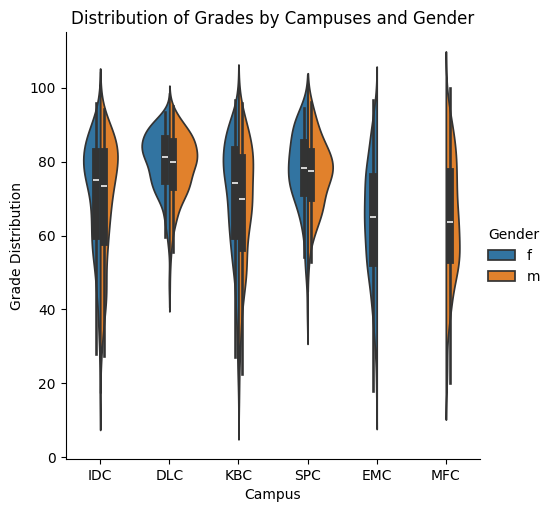

In [86]:
# Grade Distribution for each campus
generate_catplot(data=combined_result, 
    x="Campus", y="Grade", hue="Gender", 
    kind="violin", split=True, 
    y_label="Grade Distribution",
    title="Distribution of Grades by Campuses and Gender")

Interestingly, it would appear that the East Meadows (EMC) campus is only attended by female students while the Meadow Fair Campus (MFC) is only attended by male students. The grade distribution of both campuses were also similar to each other. This will be flagged as a potential abnormality in the underlying dataset. 

From this plot, we can also see that female students tended to have a lower grade median comapred to male students. Of these campuses, KBC had the most distinctive difference in medians. This may suggest that male students are better performers. However, prior filtering may have also removed a larger proportion of female students compared to male students. 

When comparing spreads, both DLC and SPC had tighter distributions compared to the other campuses. This is in agreement with the above descriptive statistics table.

#### Cumulative Grade Distributions Across Campuses

While we could plot the count of each cumulative grade across the different campuses, there are a large number of students to consider and as seen in the tables above, the number can vary quite greatly across campuses. Hence, we will plot the proportion of students instead.

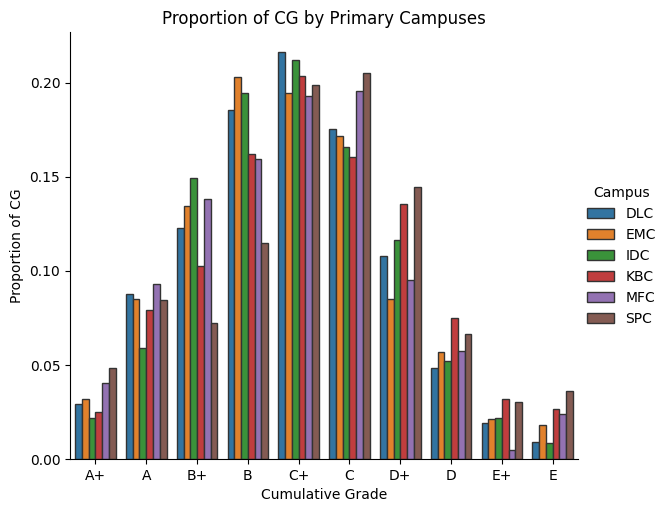

In [31]:
# Proportion of CGs by campus
plot_proportion(
    data=combined_result,
    group_columns=['Campus'],
    target_column='Cumulative Grade',
    kind='bar',
    hue='Campus',  # Different colors for each campus
    y_label = "Proportion of CG",
    title="Proportion of CG by Primary Campuses")

As expected from the previously visualised histogram, there is a larger proportion of students that have achieved a cumulative grade of C+ across the campuses. 

Of note, the EMC campus had a larger proprotion of students achieving B compared to C+. This was also the case at SPC where more students achieved C rather than C+. Additionally, when comparing proportions, more students at SPC achieved an A+ grade compared to the other three campuses. This could be due to the number of students at each campus. As SPC had a smaller number of students, there would be a high proportion of students who achieved this grade even if count-wise, the number of students with an A+ grade was comparable or even less than the other campuses.

#### Distribution of Modified Assessments and VET subjects Across Campuses

Since modified assessment and VET subjects made up the bulk of the missing values as identified above, it would be interesting to visualise how they are distributed among the students at various levels. Here, we are plotting based on the campuses.

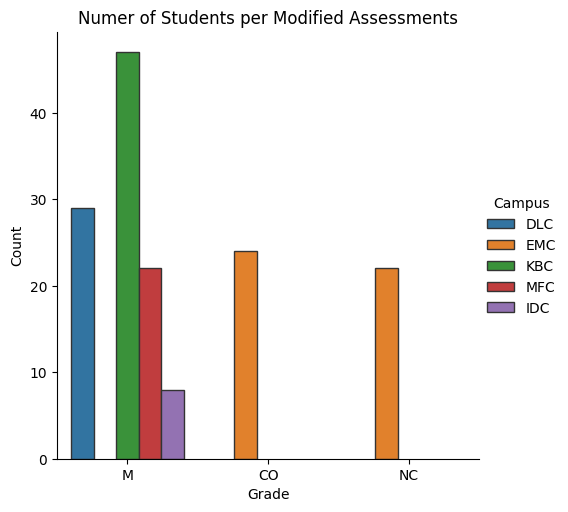

In [32]:
# Identifying the number of modified assessments and VET subjects taken per campus
generate_catplot(data=df_mod, 
    x="Grade", hue="Campus", 
    kind="count", 
    x_order=['M','CO','NC'], # Specifying the order of the x_axis categories
    title="Numer of Students per Modified Assessments")

As shown, KBC had the most number of students that undertook modified asessments. Additionally, DLC also had a higher number of students undertaking modified assessments compared to IDC and MFC. This may be part of the reason why the DLC students displayed a higher academic performace than IDC students in the above analysis.

Interestingly, EMC was the only campus than had students undertaking VET subjects. This campus may be the only campus in the Siruis College group that offer VET subjects. Given the above violin plot, this would also suggest that only female students were undertaking VET subjects.

<a id="yearlevel-analysis"></a>
#### 4.4.2 Year Level Analysis 

For this analysis, we will be looking at:
* Distribution of cumulative grades by year level
* The number of modified assessments or VET subjects at each year level

#### Grade Distributions Across Year Levels

In [33]:
# Re-sorting the year levels as they are not in the desired order
# List to order year levels
year_level_order = ["Foundation", "Year 1", "Year 2", "Year 3", "Year 4", "Year 5", "Year 6", "Year 7", "Year 8", "Year 9", "Year 10", "Year 11", "Year 12"]

# Descriptive statistics for the WAM and GPA year level-wise
des_stat(combined_result, group_col='Year Level', value_col='Grade').sort_values(by='Year Level', key=lambda col: pd.Categorical(col, categories=year_level_order, ordered=True))
    # 'key' allows for modification of the column while preserving the initial dataframe (input: column, output: transformed version)
    # 'lambda': takes our column as input and turns its values categorical for sorting

,Year Level,n,mean,median,std,min,25th %ile,75th %ile,max
0,Foundation,205,77.40,79.92,11.30,39.71,71.92,85.46,96.08
1,Year 1,225,77.78,78.46,8.75,46.21,72.54,84.29,93.33
5,Year 2,213,80.17,81.83,8.69,44.96,74.92,86.25,94.21
6,Year 3,219,78.49,79.46,7.82,54.21,73.21,84.65,94.71
7,Year 4,219,79.33,80.00,7.89,57.46,74.12,85.33,93.50
8,Year 5,229,78.62,79.81,9.11,42.92,73.14,84.63,94.41
9,Year 6,244,79.89,80.93,8.78,52.90,73.64,86.87,95.55
10,Year 7,314,64.80,65.83,15.09,19.38,54.58,76.25,96.67
11,Year 8,307,69.96,70.42,13.75,31.25,60.42,80.42,98.33
12,Year 9,311,61.19,60.83,16.39,17.50,49.17,74.58,96.67


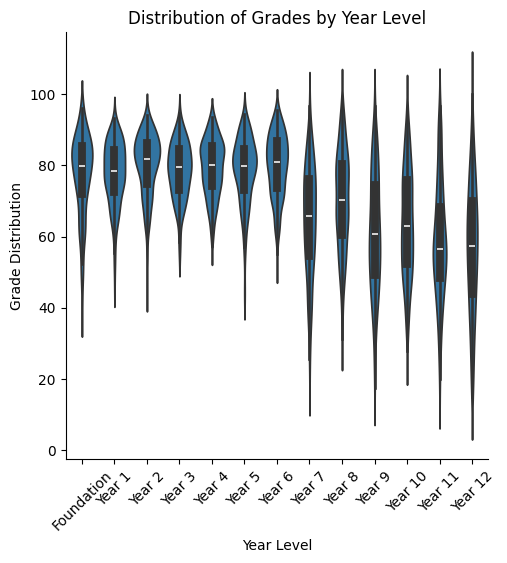

In [92]:
# Distribution of grades for each year level
generate_catplot(data=combined_result, 
    x="Year Level", y="Grade", 
    kind="violin", 
    x_order=year_level_order,
    x_tick_rotation=45,
    y_label="Grade Distribution",
    title="Distribution of Grades by Year Level")

Grade means were relatively consistent within the individual primary and secondary school cohorts. The smaller standard deviation for the primary school groups also suggested a tighter grade distribution. This is supported by the higher minimum grades in most of these group compared to the secondary year levels. Indeed, this smaller grade distribution was reflected in the violin plot shown above. Further, the secondary school cohorts had a lower mean grade compared to the primary school cohorts. These groups also had a wider spread of grade distributions which was also reflected in the relatively high standard deviation. 

It may be that more primary students were filtered out earlier, leading to a more concentrated range of values. The difference could also be due to the difficulty of the subject content taught which may affect a student's academic achievements. Another consideration for this could be the different manner in calculating the final WAM/GPA of the students as laid out in the policy booklet. These calculations do not appear to take into account a subject's difficulty and as such, subject-specific weighing could not be performed to obtain more comparable scores.

#### Grade Distributions within Primary and Secondary Cohorts

Due to the different grade systems between the primary and secondary school cohorts, we will break these up into the primary and secondary cohorts. This helps us gain a better picture of the year level's performance in relation to comparable year levels. Specifically, we aim to compare the primary cohorts with each other and the secondary cohorts with each other. 

We will use proportions as there are a large number of students and and we wish to compare between year levels.

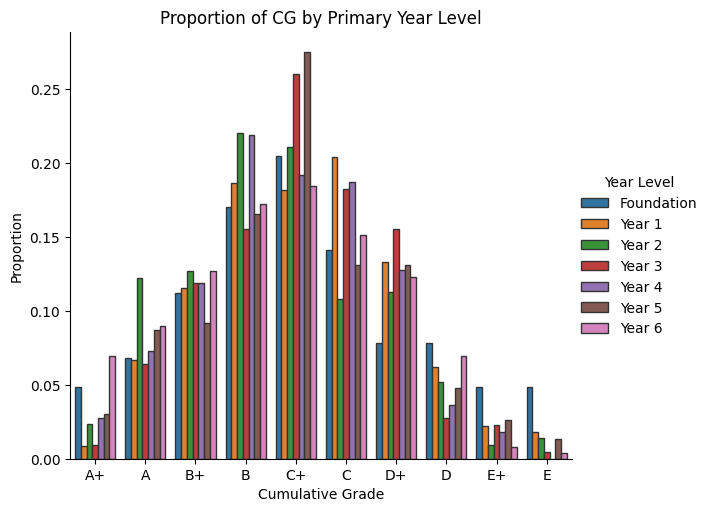

In [34]:
# Proportion of the CGs across the year levels
# Primary
plot_proportion(
    data=primary_result,
    group_columns=['Year Level'],
    target_column='Cumulative Grade',
    kind='bar',
    hue='Year Level', # Different colors for each year level
    title="Proportion of CG by Primary Year Level")

Again, the distribution of cumulative grades is similar to our previously plotted histogram.

Here, we can see that the Year 5 cohort had the highest proportion of students achieving C+ followed by the Year 3 cohort. Three year levels had a higher proportion of students that achieved a B than a C+. These were; (i) Year 1, (ii) Year 2, and (iii) Year 4. Interestingly, the Foundation and Year 6 cohorts had a higher proportion of its students achieving an A+ than the other year levels. 

Concerningly, there were also a higher proportion of Foundation students who were achieving E+ and E grades. The underlying reasons behind this may be worth looking into. Early identification of students at-risk of falling behind academically would allow for timely interventions in the form of academic or pastoral support. 

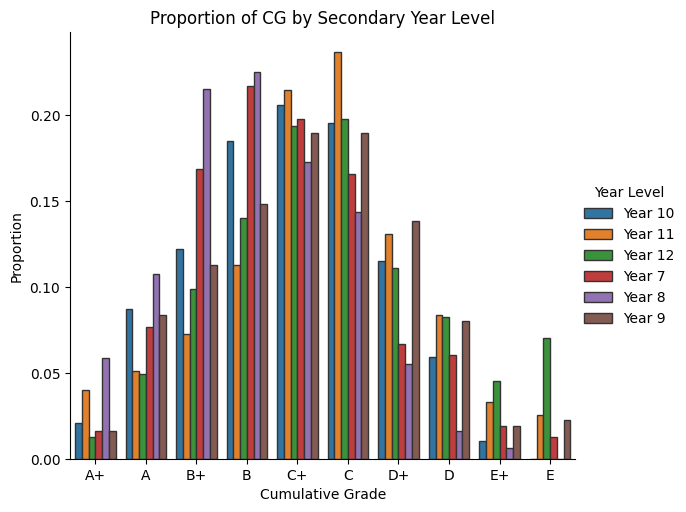

In [35]:
# Secondary
plot_proportion(
    data=secondary_result,
    group_columns=['Year Level'],
    target_column='Cumulative Grade',
    kind='bar',
    hue='Year Level',
    title="Proportion of CG by Secondary Year Level")

At a secondary cohort level, there was a higher proportion of students within Years 7, 8, and 11 who achieved a grade other than C+.

When looking at the general trend of grades, the Year 8 cohort appeared to have a right-skewed distribution of their grades with a higher proprotion achieving a A+ to B grade compared to C+ to E. This was also seen in the Year 10 cohort, with a higher proportion of students at the higher end of the grade curve. Interestingly, for both these year levels, it appears that no student had a grade of E. It is possible that more students were filtered out at these year levels due to an higher number of students having modified assessments.

What was concerning was the trend for the Year 11s and Year 12. As visualised here, there was a higher proportion of Year 11s achieving a grade of C (over 20%) compared the other grades. There were also a higher proportion of students with and E+ and E compared to the other year levels. This was also the case for the Year 12 cohort. Within this cohrt, over 5% of students had an E grade, suggesting that this year level may be struggling academically.

#### Number of Modified Assessments and VET Subjects by Year Level

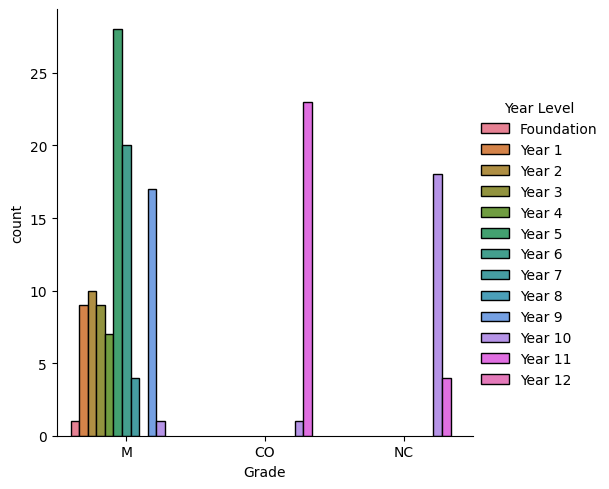

In [36]:
# Identifying the number of modified assessments or VET subjects taken per campus
# Plotting
seaborn.catplot(
    data=df_mod,
    x="Grade", 
    hue="Year Level", 
    kind="count",
    hue_order=year_level_order,  # Specify the custom order of 'Year Level'
    edgecolor="black")

The vast majority of modified assessments were undertaken at a Foundation to Year 10 level. There was a greater number of Year 5 students who had modified assessments compared to the rest of the year levels. Surprisingly, there were no Year 8 students who had modified assessments. This, in combination with the above histogram of grade distributions suggests that the Year 8 cohort are a potentially academically stronger group.

Of the Year 10 students who undertook VET subjects, a vast majority of them were deemed 'not compentent' in accordance with national training standards. Conversely, the majority of Year 11 students were deemed competent. Given this large difference in outcomes, teaching methods applied to the Year 11 cohort could be adapted for the Year 10 cohorts. Other underlying reasons behind this large discrepency could be should also be investigated.

<a id="optional"></a>
#### 4.4.2.1 Optional Extension

An interesting aspect of this analysis was the chance to identify if any students were eligible of a scholarship as laid out in the Academic Reporting Policy guide. Due to the lack of discipline record in the files, unfortunately, we can only identify student who may potentially be eligible.

Since we have already calculated the WAM/GPA, all we need to do is find the student's overall attendance and apply our filters.

In [37]:
# Are there are any students eligable for a scholarship?
# Finding average of attandance across all subjects
averaged_df = df_explore.groupby('Student Code')['Attendance'].mean().reset_index()
print(averaged_df)

# Mapping to primary and secondary cohort
# Primary
primary_result = map_yearlevel(averaged_df, primary_result, id_col='Student Code', val_cols=['Attendance'])
primary_result.head()
# Secondary
secondary_result = map_yearlevel(averaged_df, secondary_result, id_col='Student Code', val_cols=['Attendance'])
secondary_result.head()

      Student Code  Attendance
0             3004   93.040000
1             3022   82.900000
2             3079   94.925000
3             3100   90.266667
4             3112   90.250000
...            ...         ...
3286        108700   98.244444
3287        108715  100.000000
3288        108718  100.000000
3289        108721  100.000000
3290        108736   94.833333

[3291 rows x 2 columns]


,Student Code,GPA,Cumulative Grade,Gender,Year Level,Campus,Attendance
0,3004,42.000000,D+,f,Year 12,EMC,93.040000
1,3022,66.666667,C+,m,Year 12,MFC,82.900000
2,3079,100.000000,A+,m,Year 12,MFC,94.925000
3,3100,60.000000,C+,f,Year 12,EMC,90.266667
4,3112,67.500000,B,f,Year 12,EMC,90.250000


In [38]:
# Flagging students who may be eligible for scholarship
def scholarship_eligible(dataset_row):
    """
    We will iterate down each row to check a student's eligibility for a scholarship. 
    We will also flag is a student is eligible by creating a string.
    The cut-offs are based on the policies in the handout.
    """
    if (dataset_row['Cumulative Grade'] == 'A+') & (dataset_row['Attendance'] >= 90):
        return "Full Scholarship"
    elif (dataset_row['Cumulative Grade'] == 'A') & (dataset_row['Attendance'] >= 90):
        return "Half Scholarship"
    else:
        return "Not Eligible"

In [39]:
primary_result['Scholarship Eligibility'] = primary_result.apply(scholarship_eligible, axis=1)
secondary_result['Scholarship Eligibility'] = secondary_result.apply(scholarship_eligible, axis=1)

In [40]:
# Option to filter
# Primary
pri_scholar = primary_result[primary_result['Scholarship Eligibility'] != 'Not Eligible']
pri_scholar.head()
# Secondary
sec_scholar = secondary_result[secondary_result['Scholarship Eligibility'] != 'Not Eligible']
sec_scholar.head()

,Student Code,GPA,Cumulative Grade,Gender,Year Level,Campus,Attendance,Scholarship Eligibility
2,3079,100.000000,A+,m,Year 12,MFC,94.925000,Full Scholarship
67,7726,90.000000,A,m,Year 11,KBC,96.233333,Half Scholarship
72,8074,86.666667,A,m,Year 11,KBC,90.716667,Half Scholarship
74,8203,96.000000,A+,f,Year 11,KBC,95.800000,Full Scholarship
139,58303,86.666667,A,f,Year 10,EMC,91.885714,Half Scholarship


<a id="kla-analysis"></a>
#### 4.4.3 KLA Analysis 

For this analysis, we will be looking at:
* The distribution of Scores by KLAs
* The number of modified assessments or VET subjects for each KLA
* The number of KLAs taken at each campus (do campuses specialise?)
* Correlation between a subject's credit and the grade outcome (are KLAs with more periods per week harder?)

#### Grade Distributions Across KLAs

First, we can explore the differences in scores between KLAs across all year levels and campuses. We will not be using WAM/GPA as these grades are averaged across a student's subjects.

In [41]:
# Summary statistics across all KLA
# We also removes the 'VET' subjects from the final table as no scores are given
des_stat(df_explore, 'KLA', 'Score')[~des_stat(df_explore, 'KLA', 'Score')['KLA'].isin(['VET'])] 

,KLA,n,mean,median,std,min,25th %ile,75th %ile,max
0,ART,3654,76.53,78.0,11.64,0.0,70.00,85.0,100.0
1,ENG,3297,74.83,77.0,13.00,12.0,67.00,84.0,100.0
2,HPE,3181,78.76,81.0,13.14,8.0,72.00,88.0,100.0
3,HUM,3175,73.16,75.0,15.66,0.0,64.00,85.0,100.0
4,LAN,1980,77.06,80.0,15.60,0.0,68.75,88.0,100.0
5,LS,261,38.27,38.0,23.24,0.0,19.00,58.0,93.0
6,MAT,3311,74.48,79.0,18.88,3.0,64.00,89.0,100.0
7,RV,2183,84.58,88.0,12.54,18.0,79.00,94.0,100.0
8,SCI,1906,73.89,77.0,15.41,0.0,65.00,86.0,99.0
9,ST,1545,76.67,78.0,10.48,31.0,70.00,84.0,100.0


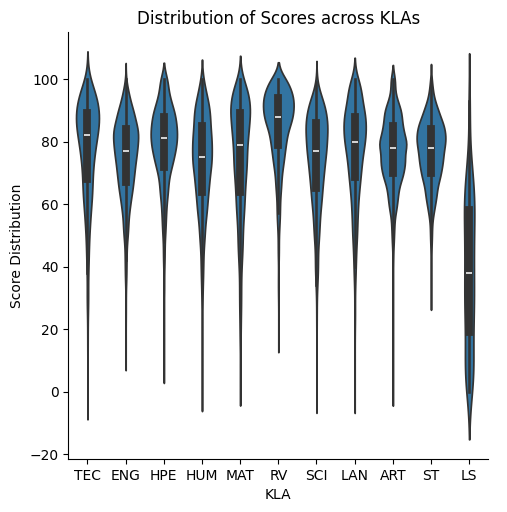

In [101]:
# Visualising distributions 
generate_catplot(data=df_explore[~df_explore.KLA.str.contains('VET')], # Drop 'VET' again as it has no scores
    x="KLA", y="Score", 
    kind="violin",
    #x_tick_rotation=45,
    y_label="Score Distribution",
    title="Distribution of Scores across KLAs")

We can see that the ART KLA has the greatest number of students while the learning support KLA (LS) has the least. LS was also the lowest performing KLA as students only achieved a mean score of 38.27. It also had a wider distribution of scores with a standard deviation of 23.24. This suggests a wide difference in abilities of students undertaking these subjects. The smaller number of students may also be part of the reason for this wider spread.

Most of the subjects saw students receive a minimum of 0 marks which was concerning. With the exception of LS and SCI, all KLAs had a maximum score of 100. Additionally, all the KLAs had a large standard deviation (over 10.00), indicating a wide distribution of scores across students. Again, this suggests a wide difference in student achievements within the KLAs and should be investigated further. Potential reasons could be misalignments between the student's learning style and their educator's teaching style. There could also be external factors underlying a student's poor performance in a KLA such as having a non-English speaking background.

The ST KLA showed the most consistent achievements in scores with a substantially higher minimum mark (31.0) and smaller standard deviation (10.48) compared to the other KLAs. This could be because subject content was easier for students to grasp or there was more support for students within this KLA.

While we can directly compare KLAs between the cohort levels, it is worth keeping in mind that underlying system to calculate the grades are complex. As discussed above, the systems do no necessarily take into account individual subject difficulty. This may affect the final grades and thus, interpretation. Additionally, there are some KLAs that are not available at a primary school level (such as SCI and TEC), hindering proper comparisons between KLAs. As such, we can have a closer look at the variablity in the scores of the KLAs by primary and secondary cohorts.

In [42]:
# Descriptive statistics of primary and secondary cohorts scores across KLAs
# Primary
des_stat(df_explore[
        df_explore['Year Level'].str.contains('Foundation') | 
        df_explore['Year Level'].str.contains(r'Year\s[1-6]$')].reset_index(drop=True), 'KLA', 'Score')

,KLA,n,mean,median,std,min,25th %ile,75th %ile,max
0,ART,2968,76.53,77.0,10.85,15.0,70.0,84.00,100.0
1,ENG,1518,75.64,77.0,11.87,23.0,69.0,84.00,100.0
2,HPE,1553,82.92,83.0,9.81,33.0,77.0,89.00,100.0
3,HUM,1335,75.38,76.0,12.86,13.0,67.0,85.00,100.0
4,LAN,1344,78.82,81.0,13.90,22.0,71.0,89.00,100.0
5,LS,145,21.97,22.0,14.05,0.0,8.0,33.00,50.0
6,MAT,1534,83.25,86.0,12.71,18.0,77.0,92.75,100.0
7,RV,1534,85.62,89.0,12.73,26.0,80.0,95.00,100.0
8,ST,1545,76.67,78.0,10.48,31.0,70.0,84.00,100.0


At a primary level, the academic achievements of students were relatively consistent with the exception of the learning support subjects. These subjects saw students achieve a mean score of 21.97 with some receiving a score of 0. As stated in the Academic Reporting Policy, these are not reflected in the final WAM/GPA. Despite that, it may still be a cause of concern that the maximum score received was 50. Modifications to teaching strategies may be required to improve student outcomes in this area.

In [43]:
# Secondary
des_stat(df_explore[ # First we filter to obtain the Years 7 - 12
        df_explore['Year Level'].str.contains(r'Year\s[7-9]') | 
        df_explore['Year Level'].str.contains(r'Year\s[1][0-2]')].reset_index(drop=True), 'KLA', 'Score')[~des_stat(df_explore[
        df_explore['Year Level'].str.contains(r'Year\s[7-9]') | # Then we remove the 'VET' subjects
        df_explore['Year Level'].str.contains(r'Year\s[1][0-2]')].reset_index(drop=True), 'KLA', 'Score')['KLA'].isin(['VET'])]

,KLA,n,mean,median,std,min,25th %ile,75th %ile,max
0,ART,686,76.54,78.0,14.60,0.0,70.0,86.75,100.0
1,ENG,1779,74.15,76.0,13.86,12.0,65.0,84.00,100.0
2,HPE,1628,74.79,78.0,14.61,8.0,66.0,86.00,100.0
3,HUM,1840,71.54,74.0,17.24,0.0,61.0,85.00,100.0
4,LAN,636,73.34,77.5,18.15,0.0,62.0,88.00,100.0
5,LS,116,58.64,60.0,14.84,0.0,52.0,66.00,93.0
6,MAT,1777,66.91,69.0,20.04,3.0,54.0,83.00,100.0
7,RV,649,82.12,85.0,11.70,18.0,77.0,90.00,99.0
8,SCI,1906,73.89,77.0,15.41,0.0,65.0,86.00,99.0
9,TEC,736,77.15,82.0,16.61,0.0,68.0,89.00,100.0


Again, the learning support subject showed the lowest mean among the scondary school KLAs. Many of these KLAs also saw a minimum value of 0 and a maximum of 100. This indicates a wide variety of student abilities and should be investigated further. The large standard deviations also suggest a wide spread in marks which supports this hypothesis.

Now we can explore the distribution of grades (not cumulative grades) across the KLAs within the primary and secondary schools. We do this as the two schools have different grading systems and it would be difficult to make a direct comparison between the KLAs.

As the main 'df_explore' dataset has modified/VET subjects and learning support subjects included, we can group them together under a 'special' category as they are treated different than normal grades when calculating GPA/WAM.

In [44]:
# List of grades to include in visualisation
grades_incl = ["A+", "A", "B+", "B", "B1", "B2", "C+", "C", "C1", "C2", "C3", "C4", "C5", "D+", "D", "E+", "E"]

# Mapping the grades to include or exclude
df_explore['Grade for Figures'] = df_explore['Grade'].apply(lambda g: g if g in grades_incl else 'Excluded')
    # 'lambda' is used to map the letters in 'grades_incl' to their corresponding grades. If there is no match, 'Excluded' is mapped instead.

In [45]:
# Distribution of Grades
# Filtering out uncessary data (where 'KLA' is 'LS' or 'VET' and 'Grade for Figures' has 'Excluded')
sub_excl = ['VET','LS']
df_filtplt = df_explore[~df_explore['KLA'].isin(sub_excl)]
df_filtplt = df_filtplt[df_filtplt['Grade for Figures'] != 'Excluded']

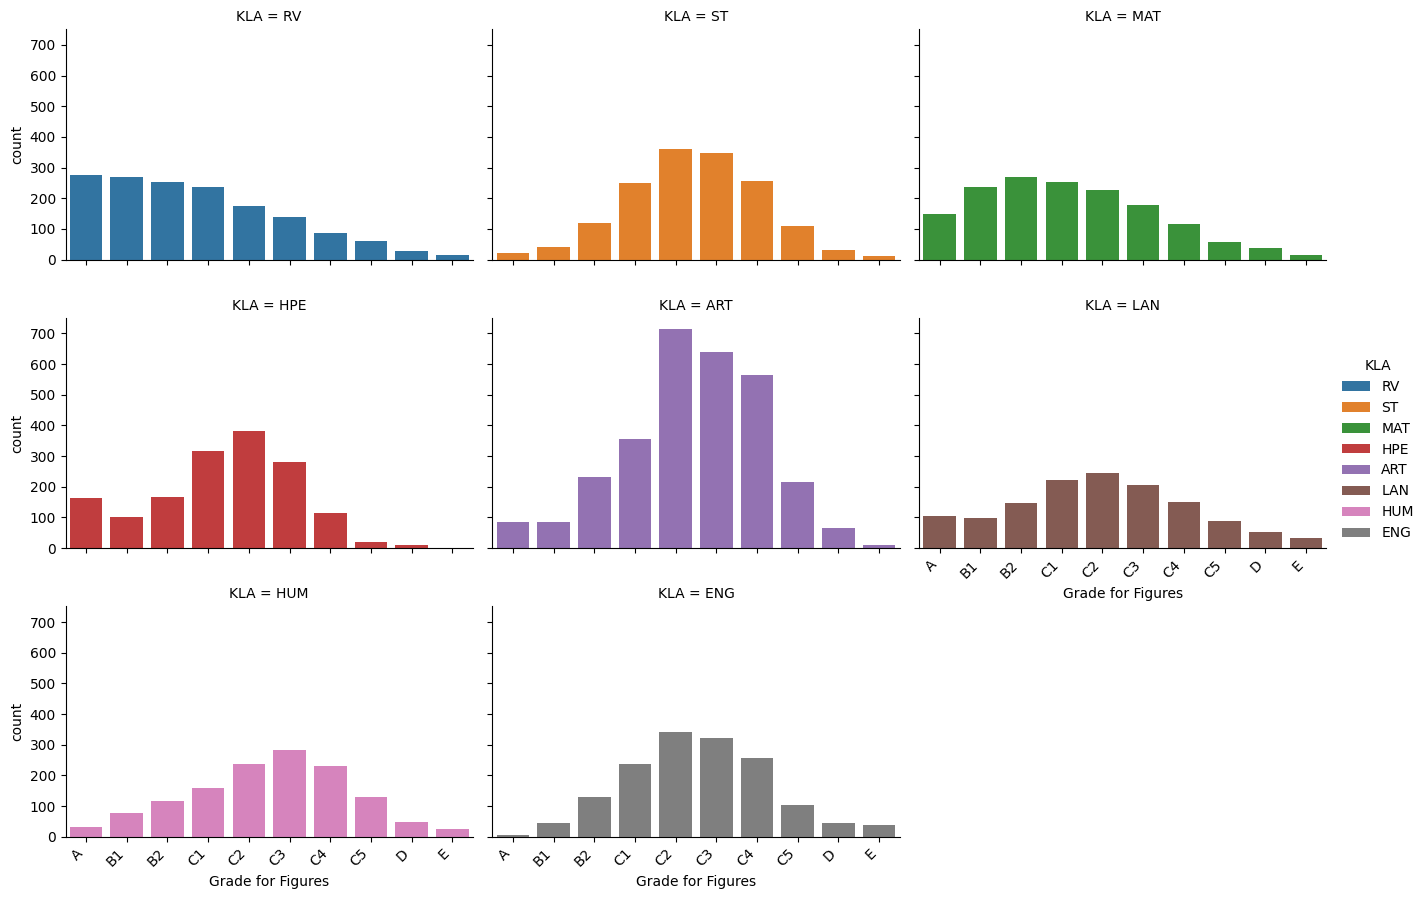

In [46]:
# Distribution at a primary level
pri_kla = seaborn.catplot(
    data=df_filtplt[
        df_filtplt['Year Level'].str.contains('Foundation') | 
        df_filtplt['Year Level'].str.contains(r'Year\s[1-6]$')].reset_index(drop=True).sort_values(by=["Grade for Figures"]), 
    x='Grade for Figures',
    hue='KLA', 
    kind='count',
    col='KLA',    # Facet by KLA
    col_wrap=3,   # Wrap the facets into multiple rows (adjust as needed)
    height=3,     # Height of each facet
    aspect=1.5,   # Aspect ratio of each facet
)
for axis in pri_kla.axes.flat:    
    for label in axis.get_xticklabels():
        label.set_rotation(45)  # Rotate each tick label
        label.set_horizontalalignment('right')  # Align labels to the right

# Plot
plt.show()

As shown, several of these KLAs were normally distributed, with most students achieving grades within C1 to C4. Of the KLAs that were not normally distributed, the RV KLA demonstrated a right-skew with most students achieving A to C1 grades. This suggests that this KLA was relatively easier compared to other KLAs. The MAT KLA was also slightly similar, with only a slight dip in the number of students achieving A and B1 grades.

It is worth noting here that the distribution of grades per KLA may be affected by the number of students taking each KLA. For example, there are around 700 students achieving the C2 grade in the ART KLA followed by around 600 and 500 for the C3 and C4 grades. Comparatively, the highest number of students for a grade in the MAT KLA was around 300.

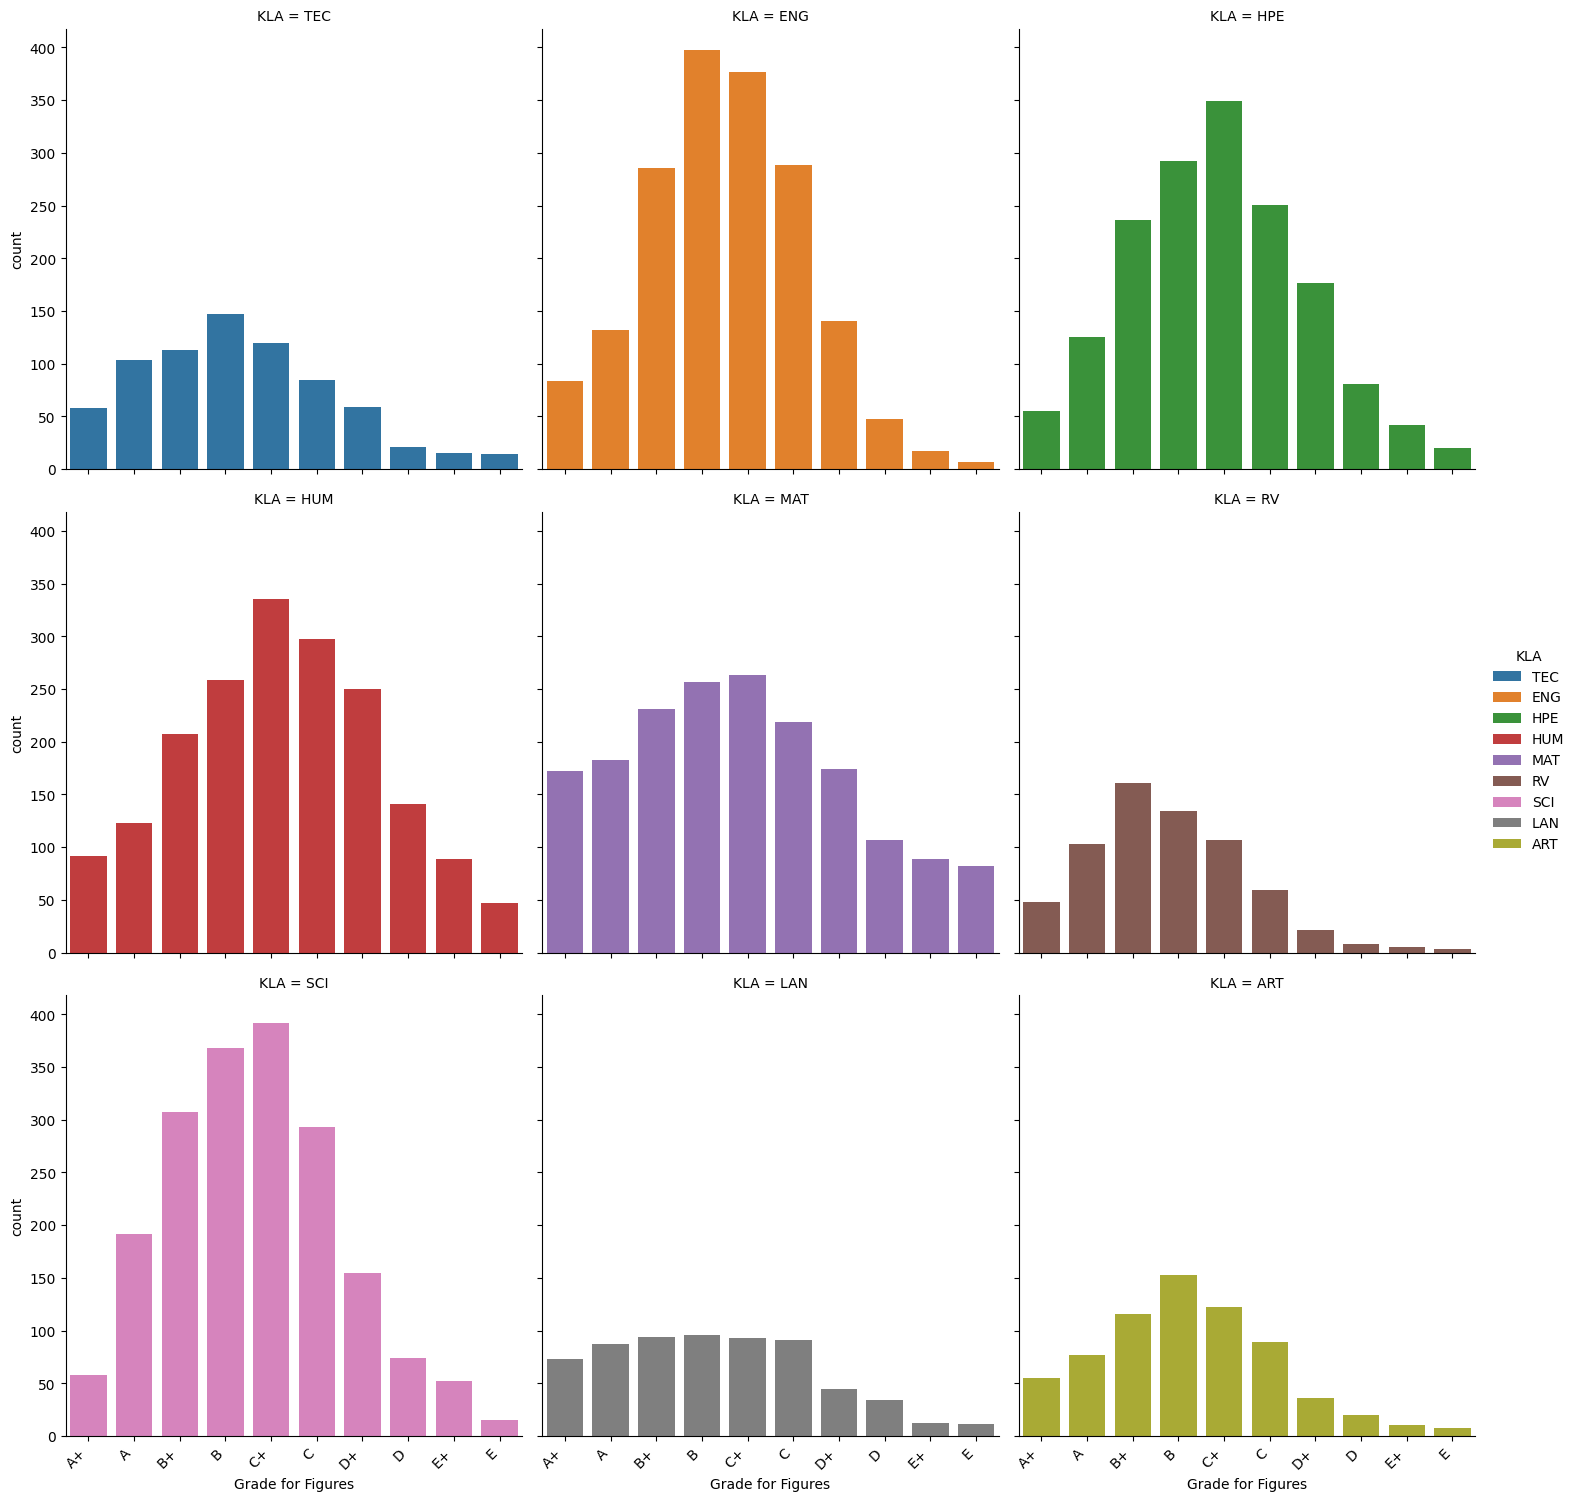

In [47]:
# Distribution at a secondary level
sec_kla = seaborn.catplot(
    data=df_filtplt[
        df_filtplt['Year Level'].str.contains(r'Year\s[7-9]') | 
        df_filtplt['Year Level'].str.contains(r'Year\s[1][0-2]')].reset_index(drop=True), 
    x='Grade for Figures', 
    order= ["A+", "A", "B+", "B", "C+", "C", "D+", "D", "E+", "E"], # Setting order required
    hue='KLA', 
    kind='count',
    col='KLA', # Facet by KLA
    col_wrap=3, # Wrap the facets into multiple rows (i.e. how many columns do we want the figure to have?)
)
# Rotating labels over the facets
for axis in sec_kla.axes.flat:    
    for label in axis.get_xticklabels(): # Getting the label positions
        label.set_rotation(45)  # Rotate each tick label
        label.set_horizontalalignment('right')  # Align labels to the right

# Plot
plt.show()

A similar picture emerges at the secondary level. Here, most KLAs saw a majority of students achieving grades of B+ to C. Again, this may be due to the larger number of students within each KLA, allowing the scores to settle towards a normal distribution. 

Both the RV and ART KLAs showed a relatively right-skewed distribution with more students achieving grades of A+ to B compared to grades of C to E. This suggests that students within these KLAs performed better compared to students in other KLAs. Alternatively, these KLAs could also have content that was more accessible and easier to understand relative to the other KLAs, leading to improved student achievement. 

Interestingly, the LAN KLA saw an almost consistent number of student achieve B+ to C grades. This distribution suggests a potental wide varity of abilities within the student cohort and could be investigated further. For example, students with varying fluency levels for their chosen language could be placed in the same class, increasing the variability of the final scores. To obtain a better understanding of a group's ability, these language classes could be divided by fluency levels.

#### Number of Modified Assessments Across KLAs

While they are not included in the final grade calculations, modified assessments, learning support and VET subjects may still impact a student's mainstream academic achievements and should not be disregarded entirely. As such, we can also have a look at the distributed scores within these KLAs.

In [48]:
# Identifying the number of modified assessments or VET subjects for each KLA
# Creating smaller subset to make it easier to deal with
df_modassess = df_explore[df_explore['Grade for Figures'] == 'Excluded']
print(df_modassess) # Checking
#pd.DataFrame(df_modassess)
#df_modassess.style

       Student Code Gender    Class Code               Subject  Score Grade  \
160           58753      f   E0710-LTR-2  Literacy Foundations   70.0    Y7   
161           58753      f  E0710-NUM-4B  Numeracy Foundations   68.0  Y6.5   
170           77287      f     D06-MAT-D  Mathematics (Year 6)    NaN     M   
282           68260      f   K0710-LTR-4  Literacy Foundations   93.0    Y9   
283           68260      f   K0710-NUM-6  Numeracy Foundations   50.0    Y5   
...             ...    ...           ...                   ...    ...   ...   
25137         76624      m   I0710-LTR-6  Literacy Foundations   35.0  Y3.5   
25225         91405      m    I04-LTRS-1      Literacy Support   31.0    Y3   
25235        101293      m      S01-LTRS      Literacy Support    3.0    YF   
25341         89503      m    I04-LTRS-1      Literacy Support   23.0    Y2   
25372         97648      f   I0710-NUM-1  Numeracy Foundations   63.0    Y6   

      Behaviour Effort  Attendance  Credit  KLA Cut

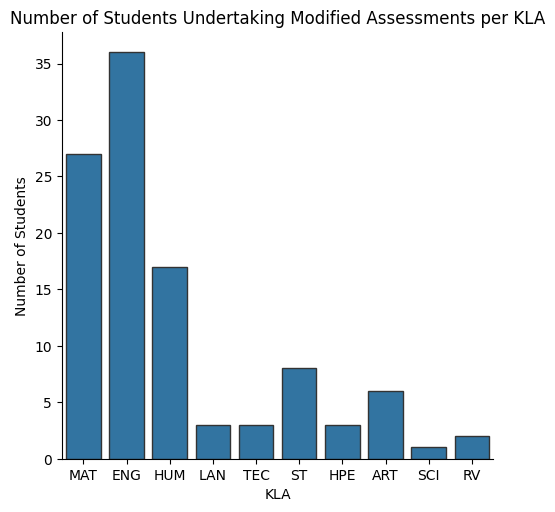

In [49]:
# Plotting modified assessments by KLA
generate_catplot(data=df_modassess[df_modassess['Grade'] == 'M'], 
    x="KLA", 
    kind="count", 
    y_label="Number of Students",
    title="Number of Students Undertaking Modified Assessments per KLA")

From the barchart above, we can see that the ENG KLA has the highest number of students taking modified assessments followed by MAT. This suggests that these two KLAs may be harder than the other KLAs. Conversely, it may also be that more students are taking subjects that fall within these KLAs.

The SCI KLA has the least number of students. This is potentially due to SCI only including secondary school students compared to ENG and MAT which include both primary and secondary students.

#### Proportion of Students per KLA

It would also be interesting to identify the number of KLAs being studied at each campus. This will also us to build a picture of the number of classes being held at each campus. We can also identify if there are any specific KLAs that are studied at a greater rate at a specific campuses.

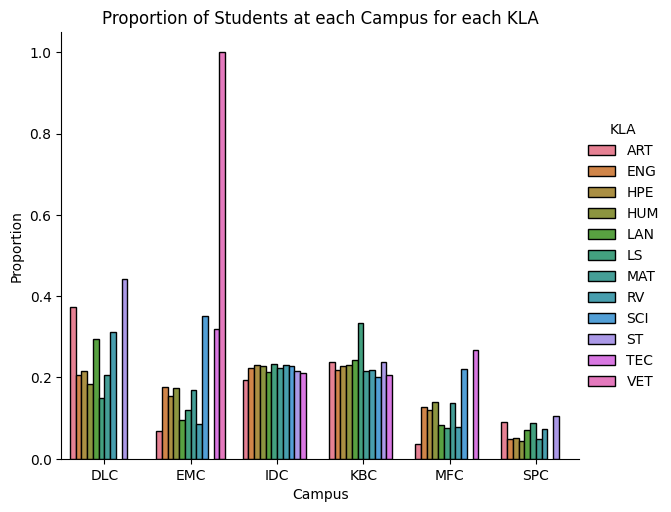

In [50]:
# Number of KLAs taken per campus
plot_proportion(
    data=df_explore,
    group_columns=['KLA'],
    target_column='Campus',
    kind='bar',
    hue='KLA', # Different colors for each year level
    edgecolor="black",
    title="Proportion of Students at each Campus for each KLA")

As shown in the plot, the majority of ST and ENG subjects were undertaken at DLC. As expected, all students who undertook a VET subject attended EMC. This suggests that EMC is a campus that specialises in teaching VET subjects to students. Alternatively, it may also be part of a data entry error as discussed above (where it appeared that only female students attended EMC). Additionally, there was a smaller proportion of student within each KLA at SPC which was to be expected given the smaller student body size relative to the other campuses. 

IDC also appeared to have a consistent proportion of students across all the KLAs, indicating a wider spread of interest or classes available at that campus. 

There were also two KLAs that appear to be unavilable to students at specific campuses. These were; (i) ST at EMC and MFC, and (ii) SCI at DLC and SPC. The lack of students in these KLAs suggests a lack of interest in the KLA at those campuses or a lack of teachers for those subjects.

#### Correlation Between Scores and Grades

As subjects with greater credit involve a greater number of periods per week, they may also be associated with a greater workload or difficulty.
Thus, we will examine if there is any correlation between a subject's credit and a student's grade outcome

For these, we will use the the dataset with the modified assessments, VET subjects, and learning support subjects filtered out. This allows us to obtain a clearer picture of the potenetial correlation between the two variables.

In [51]:
# We can first perform a dataset-wide analysis to identify any correlations. 
credit_score_corr = df_filtplt[['Credit', 'Score']].corr() # Simple correlation just to obtain a braod picture
print(credit_score_corr)

          Credit     Score
Credit  1.000000 -0.076338
Score  -0.076338  1.000000


Unfortunately, the correlation here is quite weak, suggesting that there is not much of a linear relationship between the two variables. 
However, this does not mean that there is no correlation at individual levels. We can dig into this further.

In [52]:
# Function to correlate score and credit
# This is essentially the same as above. We are just performing the correlation analysis at a specific level rather than using the whole dataframe.
def corr_func(dataset_name, val_col, var_1="Score", var_2="Credit"):
    """
    Function to perform correlation analysis between two variables.

    Important Notes:
    - val_col: the level that we want to perform the analysis at
    - var_1: first variable of interest
    - var_2: second variable of interest
    """
    # Making an empty list
    correlation_dataset_name = []

    # Looping over dataframe to correlate the two variables
    for var in dataset_name[val_col].unique(): # Finding each unique variable in our 'val_col'
        var_data = dataset_name[dataset_name[val_col] == var].dropna(subset=[var_1, var_2]) # Obtaining the columns of interest and dropping rows with zeros
        if len(var_data) > 1: # Making sure that there is more than one row of values
            corr, p_value = stats.pearsonr(var_data[var_1], var_data[var_2]) # Performing Pearson's correlation
            correlation_dataset_name.append((var, corr, p_value)) # Attaching new row with the correlation
        
    # Convert to DataFrame for easy viewing
    correlation_dataset_name = pd.DataFrame(correlation_dataset_name, columns=[val_col, 'Correlation', 'P-value'])
    # Returning dataframe
    print(correlation_dataset_name)

In [53]:
# At KLA level
corr_func(df_filtplt,val_col='KLA')

   KLA  Correlation       P-value
0  TEC     0.256404  1.633597e-12
1  ENG    -0.039220  2.432079e-02
2  HPE    -0.324440  7.239322e-79
3  HUM    -0.119168  1.626308e-11
4  MAT     0.306773  4.322895e-73
5   RV    -0.014309  5.040118e-01
6  SCI    -0.123070  7.048358e-08
7  LAN    -0.083083  2.147398e-04
8  ART     0.002992  8.565052e-01
9   ST    -0.065435  1.009122e-02


In [54]:
# At Campus level
corr_func(df_filtplt,val_col='Campus')

  Campus  Correlation       P-value
0    KBC    -0.086425  9.465493e-11
1    MFC    -0.152723  6.459868e-16
2    EMC    -0.098719  1.485339e-09
3    DLC    -0.017986  1.659994e-01
4    IDC    -0.033599  1.265004e-02
5    SPC    -0.081023  2.175169e-03


In [55]:
# At year level
corr_func(df_filtplt,val_col='Year Level')

# Note that this will return a warning. 
# This is related to the Year 11 and Year 12 cohort as there is no correlation coefficient (this means no correlation between the scores and grades at these two levels).

    Year Level  Correlation       P-value
0       Year 7    -0.044125  1.967539e-02
1       Year 9     0.035881  9.908665e-02
2      Year 10     0.027387  2.249468e-01
3   Foundation    -0.194765  1.004383e-13
4       Year 8    -0.052745  1.509938e-02
5       Year 4     0.010037  6.588800e-01
6       Year 1    -0.034420  1.227249e-01
7       Year 3     0.067558  2.809411e-03
8       Year 5     0.122495  4.590586e-08
9       Year 6     0.024576  2.584698e-01
10     Year 12          NaN           NaN
11     Year 11          NaN           NaN
12      Year 2    -0.036174  1.150559e-01


C:\Users\barca\AppData\Local\Temp\ipykernel_186832\2358625181.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = stats.pearsonr(var_data[var_1], var_data[var_2]) # Performing Pearson's correlation


Unfortunately, as shown by the above correlation analysis, there is no strong correlation between a subject's credit and the student's score. This suggests that there may be other factors affecting a student's performance. Such factors could include:
1. Student engagement with the topic: Are they submitting assignments and attending classes? Do they ask questions about the content?
2. Teaching method effectiveness: Different students have different learning styles - how does different teaching styles affect their performance?
3. Student environment: Do students have a good support system and environment to enagage with their studies?

We could conduct a regression analysis to tease out some of these relationships with our data. We could also conduct clustering analysis to better understand the relation of students at each of the campus, year-level, and KLA level. This would allow us to see if groups of students within a target group of interest (such as KLA) have more academic profiles and performances. However, due to the time constraints of this task, we will not.

<a id="task1takeaaways"></a>
### 4.5 Key Takeaways

1. Academic performances were consistent between primary and secondary cohort. Most students achieved grades between B and C.
2. Shepparton Campus appear to be the highest performing campus with a higher mean and tighter grade distribution.
3. Year 11 and Year 12 groups are flagged as potential high-risk cohorts, both groups having the lowest GPAs of all year levels.
4. Modified assessments appear to be highly concentrated in Year 5 and Year 6 cohorts and the ENG and MAT KLA.

<a id="Task-2"></a>
## 5. Task 2: Predictive Modelling - Mathematics 1 Performance (Year 7 Only) 

This section deals with the requested Task 2 from the Data Analysis Task handout. Here, we will be building a model to predict the performance of Year 7 students in Mathematics 1. We will be working with the cleaned 'df_CGcalc' dataframe.

<a id="preparing-datasets"></a>
### 5.1 Preparing Datasets

We will first prepare the relevant dataframes for this task. To preserve the original 'df_CGcalc', we make a copy of it.

In [10]:
# Making a copy of 'df_CGcalc' for this task
df_task2 = df_CGcalc
#print(df_task2)

In [11]:
# Including the Year 7s
df_yearsev = df_task2[df_task2['Year'].str.contains(r'Year\s[7]\s[A-Z][A-Z][A-Z]')] # Subsetting based off Year 7s only
# Dropping columns we don't want
df_yearsev = df_yearsev.drop(columns=['Credit', 'KLA']) 
#print(df_yearsev)
df_yearsev['Grade'].unique() # Checking
#df_yearsev.info()

array(['D+', 'C+', 'C', 'B+', 'B', 'A', 'D', 'E', 'E+', 'A+'],
      dtype=object)

There are several steps we need to take before building and testing the model.
1. Turning our strings in the behaviour, effort, and attendance columns to ordinal values as they will also be used to predict grades
2. Making 'Gender' ordinal as it may be predictive for academic performances. We can remove it later if it leads to overfitting or underfitting
3. Aggregating the average of the features so we have a value for every student. As each score and grade are-subject specific, we aggregate to obtain student-level features. We will use these to predict Mathematics 1 grades per student. This also allows us to have a cleaner dataframe, allowing us to keep as much data in the model as possible, thus making modelling easier.

In [12]:
# Making dictionaries for our columns of interests
letter_dic = {'A+':0,'A':1,'B+':2,'B':3,'C+':4,'C':5,'D+':6,'D':7,'E+':8,'E':9} 
gender_dic = {'f':0,'m':1}
cutoff_dic = {'G2':0,'G3':1}

# Making a copy to avoid 'SettingWithCopyWarning'
df_yearsev = df_yearsev.copy()

In [13]:
# Converting
# Replace letter grades with numerical values
    # '.loc[]' allows us to access a group of columns/rows and its associated rows/columns from a dataframe via its label
for col in ['Behaviour','Effort','Grade']:
    df_yearsev.loc[:, col] = df_yearsev[col].map(letter_dic).astype(int) # here we access a specific column (such as 'Grade') along with its associated row values
# Replace gender
df_yearsev.loc[:, 'Gender'] = df_yearsev['Gender'].map(gender_dic).astype(int)
# Replace Cutoff Group
df_yearsev.loc[:, 'Cutoff Group'] = df_yearsev['Cutoff Group'].map(cutoff_dic).astype(int)
# Check
print(df_yearsev)

       Student Code Gender        Year   Class Code  \
0            105844      1  Year 7 KBC  K07S1-DIG-3   
1            105844      1  Year 7 KBC   K07-ENG1-6   
2            105844      1  Year 7 KBC  K07-HPE1-15   
3            105844      1  Year 7 KBC   K07-HUM1-1   
4            105844      1  Year 7 KBC   K07-MAT1-4   
...             ...    ...         ...          ...   
25395        105202      1  Year 7 KBC   K07-MAT1-1   
25396        105202      1  Year 7 KBC    K07-RV1-2   
25397        105202      1  Year 7 KBC   K07-SCI1-6   
25398        105202      1  Year 7 KBC   K07-TUR1-2   
25399        105202      1  Year 7 KBC  K07S1-VA1-3   

                               Subject  Score Grade Behaviour Effort  \
0                 Digital Technologies   60.0     6         1      4   
1                            English 1   77.0     4         1      3   
2      Health and Physical Education 1   65.0     5         0      3   
3                         Humanities 1   59.0     6

Now we can exclude the Mathematics 1 rows as we will predicting this downstream. This also ensures that we avoid any data leakage and the model is able to train itself on data unrelated to the final target we are predicting (in this case, the Mathematics 1 grade).

In [14]:
# Excluding the Mathematics 1 rows
df_model = df_yearsev[df_yearsev['Subject'] != 'Mathematics 1'].drop('Class Code', axis=1)
print(df_model)

       Student Code Gender        Year                          Subject  \
0            105844      1  Year 7 KBC             Digital Technologies   
1            105844      1  Year 7 KBC                        English 1   
2            105844      1  Year 7 KBC  Health and Physical Education 1   
3            105844      1  Year 7 KBC                     Humanities 1   
5            105844      1  Year 7 KBC            Religion and Values 1   
...             ...    ...         ...                              ...   
25394        105202      1  Year 7 KBC                     Humanities 1   
25396        105202      1  Year 7 KBC            Religion and Values 1   
25397        105202      1  Year 7 KBC                        Science 1   
25398        105202      1  Year 7 KBC                       Turkish 1.   
25399        105202      1  Year 7 KBC                    Visual Arts 1   

       Score Grade Behaviour Effort  Attendance Cutoff Group  
0       60.0     6         1      4 

From here, we will get an aggregate of a student's scores, grades, attendance, effort, and behaviour. We do this as we are interested in predicting individual student's grades. This allows us to more efficiently handle our datasets. This also reduces reduce the amount of noise in the dataset, allowing the model to predict more accurately.

In [15]:
# Aggregating
df_agg = df_model.groupby('Student Code').agg({ # We group by individual students
    # 'first' as this is constant for each students.
    'Year': 'first',  # Keeping Year for reference
    'Gender': 'first', 
    # Finding averages as they are continuous 
    'Score': 'mean', 
    'Grade': 'mean',
    'Attendance': 'mean',
    # median as they are ordinal
    'Behaviour': 'median', 
    'Effort': 'median',
    'Cutoff Group': 'median'
}).reset_index()

# Print to check
print(df_agg)

     Student Code        Year Gender      Score     Grade  Attendance  \
0           68476  Year 7 MFC      1  78.875000      3.25   88.575000   
1           72307  Year 7 MFC      1  64.750000     4.875   98.937500   
2           72922  Year 7 KBC      0  67.142857  4.714286   92.971429   
3           74062  Year 7 EMC      0  77.750000     3.375   80.950000   
4           74119  Year 7 EMC      0  91.125000      1.25  100.000000   
..            ...         ...    ...        ...       ...         ...   
309        108223  Year 7 IDC      0  76.750000     3.125   87.237500   
310        108391  Year 7 MFC      1  75.125000       3.5   97.350000   
311        108694  Year 7 EMC      0  83.250000     2.625   79.487500   
312        108700  Year 7 EMC      0  76.875000       3.5   98.025000   
313        108736  Year 7 EMC      0  77.500000       3.5   94.662500   

    Behaviour Effort Cutoff Group  
0         1.0    3.0          1.0  
1         1.5    5.0          1.0  
2         3.0  

As we are aiming to build a predictive model, we will be using supervised learning models. Specifically, we will be using:
1. Logistic Regression
2. Random Forest

As Logistic Regression is the most interpretable mode and can be modified to prevent overfitting, we will use this as part of our baseline investigation. The random forest model is chosen as it is able to better identify non-linear relationships that may be present in the data. The main difference in these two models are the assumptions they make about the underlying relationship between features.

Logistic Regression is a linear classifier and as such, assumes a constant linear relationship between the input feature and the target. In this case, it assumes a linear relationship between a student's score, behaviour, effort, and attendance with a student's final grade. However, this is not always the case as a student's performance could be influenced by more complex, non-linear interactions. For example, a student's efforts may only translate to higher grades if their attendance and behaviour meet certain thresholds. As a non-linear model, the Random Forest model is better able to capture these relationships more effectively. By including both a linear and non-linear model in our analysis, we can obtain a better picture of potential interactions between the features and the final Mathematics 1 grade.

We need to set up the relevant objects for modelling. We do this by saving the actual Mathematics 1 grades in a separate dataframe for mapping onto our aggregated dataframe.

In [16]:
# Extracting the target feature (Mathematics 1 Grade)
# We are also including the grades since that is what we are predicting
df_target = df_yearsev[df_yearsev['Subject'] == 'Mathematics 1'][['Student Code', 'Class Code', 'Grade']].copy().rename(columns={'Grade': 'Maths1_Grade'}) # Making a copy to preserve original dataframe

In [17]:
# Mapping the actual Mathematics 1 grade with the aggregated dataset (for later comparisons)
df_final = pd.merge(df_agg, df_target, on='Student Code')

<a id="identifying-contributing-features"></a>
### 5.2 Identifying Contributing Features

Now that we have the dataframes we need, we can begin modelling. As we are dealing with many different features, it would be interesting to see which features may contribute the most to the final Mathematics 1 grade. 

Specifically, we are interested in assessing which metric may impact student performance. This includes features such as 'Gender' which may hinder model performance as it introduces a level of bias to our dataset. As such, we may be interested in dropping it if we are not assessing gender-based performance. This would allow our model to focus on more relevant features such as scores and attendance.

In [18]:
# Identifying which features contribute the most to the Maths 1 grade
# Making a smaller dataset to build this identification model
data_id = df_final.copy()
data_id = data_id.iloc[:,np.r_[0,2:9,10]]

#Checking that we have the columns we need
print(data_id)

     Student Code Gender   Score  Grade  Attendance Behaviour Effort  \
0           68476      1  78.875   3.25     88.5750       1.0    3.0   
1           72307      1  64.750  4.875     98.9375       1.5    5.0   
2           74062      0  77.750  3.375     80.9500       1.0    2.5   
3           74119      0  91.125   1.25    100.0000       0.5    0.5   
4           74140      1  76.000  3.375     88.8750       3.0    3.0   
..            ...    ...     ...    ...         ...       ...    ...   
299        108223      0  76.750  3.125     87.2375       1.0    1.5   
300        108391      1  75.125    3.5     97.3500       1.0    3.0   
301        108694      0  83.250  2.625     79.4875       1.0    1.0   
302        108700      0  76.875    3.5     98.0250       1.0    2.5   
303        108736      0  77.500    3.5     94.6625       1.0    1.0   

    Cutoff Group Maths1_Grade  
0            1.0            0  
1            1.0            3  
2            1.0            5  
3      

In [19]:
# Defining our sample and target dataframes (X and Y respectively)
X_id = data_id.iloc[:,1:8]  # features of interest
Y_id = pd.Categorical(data_id.iloc[:,-1]) # target 

# Ranking the features
best_feat = SelectKBest(score_func=chi2, k=5) # Selecting the features and running a chi-squared test
fit = best_feat.fit(X_id,Y_id)

# Make individual data frames for the features and the score of each feature
df_scores = pd.DataFrame(fit.scores_) # Getting the scores
df_columns = pd.DataFrame(X_id.columns) # Getting the features of interest from the column names

# Combining into one dataframe and printing
features_scores= pd.concat([df_columns, df_scores], axis=1) # Concatenating column-wise
features_scores.columns= ['Features', 'Score'] # Renaming columns
features_scores.sort_values(by = 'Score')

,Features,Score
6,Cutoff Group,4.031402e-29
0,Gender,1.177400e+01
3,Attendance,2.339262e+01
4,Behaviour,3.568930e+01
2,Grade,7.745894e+01
5,Effort,8.087211e+01
1,Score,2.066823e+02


From the above table, we can see that both 'Gender' and Cutoff Group' are ranked as the least relevant features. From here, we can remove them if we wish when running our model. 

It is worth noting that sometimes, the features may still be relevant when running prediction models. This occurs as 'SelectKBest' does not consider the interactions between features (it only checks them individually against our target). In this case, 'Cutoff Group' may have some relationship with other features such as 'Effort' and 'Attendance' as a subject with a high mark range may involve more effort and require more consistent attendance in class.

For these features, it may be worth leaving them in the model as additional smaller sources of signals (i.e. ensures that there is more information in the model to predict from). 

<a id="Benchmarking"></a>
### 5.3 Benchmarking

To determine which feature combination gives the best prediction, we can run a benchmarking test for both our Logistic Regression and Random Forest models. 

First, we set up for benchmarking:

In [27]:
# Getting lists of all the features we want to test
feature_sets = {
    "All Features": ['Gender', 'Score', 'Grade', 'Attendance', 'Behaviour', 'Effort', 'Cutoff Group'],
    "No Gender": ['Score', 'Grade', 'Attendance', 'Behaviour', 'Effort', 'Cutoff Group'],
    "No Cutoff Group": ['Gender', 'Score', 'Grade', 'Attendance', 'Behaviour', 'Effort'],
    "No Gender & Cutoff Group": ['Score', 'Grade', 'Attendance', 'Behaviour', 'Effort']
}

# Consistent train-test split
X_base = df_final.drop(columns=['Maths1_Grade', 'Student Code', 'Year', 'Class Code'])
y = df_final['Maths1_Grade']
y = pd.Categorical(y) # Turn 'y' into categories for the classification

# Splitting the dataset into testing and training sets
# We set the size of the testing set to be 20% of the initial dataframe so we better train the model
X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

# Making lists to store the results and model objects that are returned
results_ls = []
model_obj = []

Making a function so we can easily run through all our feature sets of interest.

In [28]:
# Function
def benchmark_func(X_train, X_test, y_train, y_test, feat_cols, feat_label, results_ls, model_obj):
    """
    This function is to perform benchmarking on various feature sets.
    We will run the logistic regression and random forest models for classification purposes.
    The function returns a list of the results obtained from model including model prediction accuracy.
    Additionally, the model_obj list returned will allow us to plot confusion matrices for models of interest along with obtaining predicted values.

    Important Notes:
    - feat_cols: the columns from the feature set we defined above (e.g. ['Score', 'Grade', 'Attendance', 'Behaviour', 'Effort', 'Cutoff Group'] from the 'No Gender' feature set)
    - feat_label: the feature set we are modelling (e.g. 'No Gender' or 'All Features')
    """
    # Subset columns
    X_train_sub = X_train[feat_cols]
    X_test_sub = X_test[feat_cols]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sub)
    X_test_scaled = scaler.transform(X_test_sub)

    # Running Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(X_train_scaled, y_train)
    y_pred_log = log_reg.predict(X_test_scaled)

    results_ls.append({
        "Model": "Logistic Regression",
        "Feature Set": feat_label,
        "Accuracy": accuracy_score(y_test, y_pred_log),
        "Macro F1": f1_score(y_test, y_pred_log, average='macro'),
        "Weighted F1": f1_score(y_test, y_pred_log, average='weighted')
    })

    model_obj.append({
        "Model": "Logistic Regression",
        "Feature Set": feat_label,
        "Estimator": log_reg,
        "Scaler": scaler,
        "X_test": X_test_scaled,
        "y_pred": y_pred_log
    })

    # Running Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_sub, y_train)
    y_pred_rf = rf.predict(X_test_sub)

    results_ls.append({
        "Model": "Random Forest",
        "Feature Set": feat_label,
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Macro F1": f1_score(y_test, y_pred_rf, average='macro'),
        "Weighted F1": f1_score(y_test, y_pred_rf, average='weighted')
    })

    model_obj.append({
        "Model": "Random Forest",
        "Feature Set": feat_label,
        "Estimator": rf,
        "Scaler": None,  # No scaling used
        "X_test": X_test_sub,
        "y_pred": y_pred_rf
    })

#### Running Benchmarks

Now we run the models through our pre-defined feature sets.

In [29]:
# Running the model through out feature sets
for label, cols in feature_sets.items(): #.items() iterates through the feature_set object, allowing each subset to be run through the function
    benchmark_func(X_train, X_test, y_train, y_test, cols, label, results_ls, model_obj)

In [30]:
# Printing the results of the modelling and sorting by accuracy of the model
results_df = pd.DataFrame(results_ls).sort_values(by='Accuracy', ascending=False)
print(results_df)

                 Model               Feature Set  Accuracy  Macro F1  \
3        Random Forest                 No Gender  0.295082  0.243291   
5        Random Forest           No Cutoff Group  0.278689  0.170243   
2  Logistic Regression                 No Gender  0.262295  0.173204   
1        Random Forest              All Features  0.262295  0.165841   
7        Random Forest  No Gender & Cutoff Group  0.262295  0.222069   
6  Logistic Regression  No Gender & Cutoff Group  0.262295  0.173204   
0  Logistic Regression              All Features  0.229508  0.135206   
4  Logistic Regression           No Cutoff Group  0.229508  0.135206   

   Weighted F1  
3     0.278020  
5     0.255516  
2     0.237854  
1     0.245865  
7     0.247950  
6     0.237854  
0     0.203181  
4     0.203181  


We can see that the Random Forest Classifier has the best accuracy when run without the 'Gender' data included. Thus, we can conclude that the Random Forest model is better at predicting the Mathematics 1 grades of students when 'Gender' is excluded compared to the other models.

#### Checking Model Prediction Accuracy

To gain a better idea of what grades are being accurately predicted, we can plot a confusion matrix of the actual grades against the predicted grades.

In [33]:
# Getting the data from model_obj list
# 'next()' iterates down the list and retrives the next entry
best_model = next(m for m in model_obj if m['Model'] == "Random Forest" and m['Feature Set'] == "No Gender") # Iterate down and retrive the Random Forest model without gender

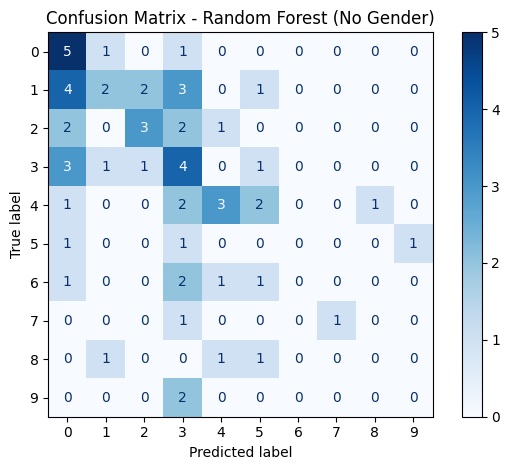

In [34]:
# Plotting the confusion matrix
# Getting the matrix
cm = confusion_matrix(y_test, best_model['y_pred'], labels=sorted(y_test.unique())) 
# Creating the object to be plotted
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(cmap='Blues') # Modifying the colour of the plot
plt.title(f"Confusion Matrix - {best_model['Model']} ({best_model['Feature Set']})") # Plotting title
plt.tight_layout()
# Displying plot
plt.show()

As shown, the model is quite accurate at predicting 'A+' grades accurately with 5 students having consistent grades. Unfortunately, it was not quite as successful with other grade combinations which may be due to the smaller sample size and lack of features available. This may also be due to imbalances in the grades of students. Specifically, in this dataset, there may be more students that have achieved grades of A+ and B, biasing the model to predicting these grades.

In [39]:
# Checking the proportion of grades within the training dataset
# Reminder: {'A+':0,'A':1,'B+':2,'B':3,'C+':4,'C':5,'D+':6,'D':7,'E+':8,'E':9} 
print(pd.Series(y_train).value_counts(normalize=True))

0    0.172840
3    0.172840
1    0.152263
2    0.144033
4    0.123457
5    0.078189
6    0.057613
8    0.041152
9    0.032922
7    0.024691
Name: proportion, dtype: float64


In [40]:
# Checking the proportion of grades within the training dataset
print(pd.Series(y_test).value_counts(normalize=True))

1    0.196721
3    0.163934
4    0.147541
2    0.131148
0    0.114754
6    0.081967
5    0.049180
8    0.049180
7    0.032787
9    0.032787
Name: proportion, dtype: float64


As we can see, A+, A, and B are the grades with the highest proportion in the training dataset. Comparatively, grades at the lower end of the scale such as D and E were less represented in the dataset. Thus, the model would not have been able to be effectively trained to predict these grades compared to higher grades.

Overall, we can say the model is modestly predictive. It was able to capture an underlying pattern in the dataset and predict the Mathematics 1 grades of students accurately around 29.5% of the time. However, given the low percentage, we cannot be completely confident in its individual predictions. The low accuracy could be due to the smaller sample size, reducing the amount of data available for the model to train on. The differences in the number of students per grade class could also partially be the reason for the lower accuracy. Finally, Random Forest treats ordinal classes as unordered categories, hindering accurate classification. Thus, models that are able to handle ordinal classes such as OrdinalClassifier should be considered. However, given the time constraints of this task, we are unable to do so.

While it may be possible to attempt to apply class balancing techniques, as can be seen above, certain grades (such as D and E) were achieved by a relatively small proportion of students. Automatically adjusting for these smaller groups could lead to model overfitting and inaccurate predictions. Additionally, while not shown, class weighing was explored and not found to have demonstrable improvements in prediction accuracy. This suggests that the model used here is already handling class imbalances well. In future, the model's performance can be compared to more complex models.

<a id="identifying-classes"></a>
### 5.4 Identifying Overperformers & Underperformers

We can now identify which classes are over or underperforming. 

We can first include the predicted grades in the initial dataframe that we ran with the moodel ('df_final').

In [72]:
# Use the feature set without gender as that was the best model
features = feature_sets['No Gender']
# Subsetting the initial dataframe to get the values for our features of interest
X_full = df_final[features] 

In [73]:
# Running our trained Random Forest Classifier model on the subsetted dataframe to predict grades
df_final['Predicted_Maths1'] = best_model['Estimator'].predict(X_full) # Appending it to the initial dataframe

To get an overview per class, we can aggregate the newly formed 'df_final' to get the mean of the actual and predicted Mathematics 1 grade. We can also find the difference in the scores per class to determine by how many grade points the model over or underestimated.

In [74]:
# Group by class
class_grades = df_final.groupby('Class Code').agg({
    'Maths1_Grade': 'mean',
    'Predicted_Maths1': 'mean'
})
# Finding difference
class_grades['Difference'] = class_grades['Maths1_Grade'] - class_grades['Predicted_Maths1']
class_grades = class_grades.sort_values(by='Difference') # Sorting by values
# Displying table
print(class_grades)

           Maths1_Grade  Predicted_Maths1 Difference
Class Code                                          
I07-MAT1-4         1.88          2.080000       -0.2
M07-MAT1-6         2.25          2.333333  -0.083333
I07-MAT1-6         2.28          2.360000      -0.08
K07-MAT1-6     2.952381          3.000000  -0.047619
K07-MAT1-4     2.681818          2.727273  -0.045455
M07-MAT1-1     2.956522          2.956522        0.0
M07-MAT1-4         2.25          2.250000        0.0
E07-MAT1-5         4.44          4.240000        0.2
I07-MAT1-1         2.96          2.640000       0.32
E07-MAT1-4      3.52381          3.095238   0.428571
E07-MAT1-1     3.909091          3.409091        0.5
E07-MAT1-6     3.833333          3.333333        0.5
K07-MAT1-1     3.608696          3.086957   0.521739


As we can see, most classes only had less than 0.5 grade points between the actual and predicted average grades. Conversely, three classes ('E07-MAT1-1', 'E07-MAT1-6', 'K07-MAT1-1') were found to have at least a 0.5 grade point difference between the actual and predicted grades. This suggests that these classes were overperforming in their Mathematics 1 achievements.

To statistically identify if the individual classes are over or underperforming, we can run a one sample t-test for each class. Given the relatively small sample size per class, we will be using a Wilcoxon Signed-Rank test for a more robust analysis.

In [75]:
# Getting individual classes
class_unq = df_final['Class Code'].unique()
# Turning our 'Maths1_Grade' column to integers so we can run the test
df_final['Maths1_Grade']=df_final['Maths1_Grade'].astype(int)
# Make list
class_ls = []

In [76]:
# Making a for loop to iterate through each class in the dataframe
for class_code in class_unq:
    #print(class_code)
    class_df = df_final[df_final['Class Code'] == class_code]

    # Running the Wilcoxon Signed-Rank test
    t_statistic, p_value = stats.wilcoxon(class_df['Maths1_Grade'], class_df['Predicted_Maths1'])

    # Making the final dataframe for comparisons
    class_ls.append({
        "Class": class_code,
        "t-statistic": t_statistic,
        "p-value": p_value
    })

# Getting the results in a dataframe
res_stats = pd.DataFrame(class_ls).sort_values(by='p-value', ascending=True)
print(res_stats) # Printing to have a look

         Class  t-statistic   p-value
11  K07-MAT1-1          0.0  0.067889
7   E07-MAT1-1          0.0  0.108809
5   E07-MAT1-6          0.0  0.108809
4   I07-MAT1-1          2.0  0.130797
6   I07-MAT1-4          0.0  0.179712
1   E07-MAT1-4          0.0  0.179712
12  K07-MAT1-4          0.0  0.317311
9   I07-MAT1-6          2.0  0.563703
2   E07-MAT1-5          6.0  0.680280
8   M07-MAT1-6          4.0  0.705457
10  K07-MAT1-6          6.5  0.782528
3   M07-MAT1-4          5.0  1.000000
0   M07-MAT1-1          1.5  1.000000


Unfortunately, none of the classes were found to be significantly over or underperforming by our model. The class that was the closest to having a statistical significance between their actual grades and predicted grades was 'K07-MAT1-1' (p = 0.068). This suggests that 'K07-MAT1-1' is very close to overachieving and this hypothesis is supported by the above calculations that found a 0.521739 grade point difference between the two values.

Future models could be improved through the inclusion of standardised data, especially for subjective variables such as behaviour and effort. Further inclusion of retrospective data would improve the model's predictive ability due to the larger sample size. 

While the model may be modestly predictive, it could still be used to flag at-risk classes and students. At a student-level, this would allow for early educational interventions such as additional tutoring sessions, provision of additional resources, and pastoral support. Where classes are under-performing relative to the model, internal reviews into the class enagement, dynamics, and curriculum could be conducted.

<a id="task2takeaaways"></a>
### 5.5 Key Takeaways

1. Random Forest Classifier without 'Gender' as an additional feature performed the best (29.5% accuracy).
2. Class 'K07-MAT1-1' was the closest to the statistically overperforming. There was a difference of 0.5 grade points between the actual mean and predicted mean of the Mathematics 1 grade. Further Wilcoxon Signed-Rank testing returned a p-value of 0.068.